# Building Bonsai BDT for Online Triggering

* Step 1 : Pull out features for classification.  These include energy deposit on wire, energy deposit of left neighbour, energy deposit of right neighbour, and layer id (radial distance).
* Step 2 : Bin these features into 11 bins, 10 with deposits, one with no deposits
* Step 3 : Train the GBDT to recognize hit wires based on these binned energy features and layer_id
* Step 4 : Build a look up table of dimention [11,11,11,18], so it has an entry for each possible combination of features
* Step 5 : Fill the table with the output of the wire GBDT
* Step 6 : Define layer features based on this output
* Step 7 : Pass layer features through event GBDT
* Step 8 : Determine signal or background based on this output

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CDCHits, CTHHits, CyDetHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter, OrderedDict
sys.path.insert(0, '../modules')
%load_ext memory_profiler
from root_numpy import root2array
import scipy.sparse

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run data_tools.ipynb

In [3]:
recbe_wiring_file = "/home/five4three2/development/ICEDUST/track-finding-yandex/data/chanmap_20160814.root"
recbe_positions = root2array(recbe_wiring_file, selection="isSenseWire == 1 && LayerID > 0 && LayerID < 19", 
                                        branches=["LayerID", "CellID","BoardID",
                                                  "BrdLayID", "BrdLocID","ChanID"])
recbe_positions["LayerID"] = recbe_positions["LayerID"] - 1

# Signal Data

In [6]:
file_base = "/home/five4three2/development/ICEDUST/"\
            "track-finding-yandex/data/MC4p/"

back_samples = ["MC4p_background_sample_3bunch-train_1.root",
                "MC4p_background_sample_3bunch-train_2.root",
                "MC4p_background_sample_3bunch-train_3.root",
                "MC4p_background_sample_3bunch-train_4.root"]
sig_samples = ["oa_xx_xxx_09010000-0000_xerynzb6emaf_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09110000-0000_2mdcao2ehzya_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09210000-0000_opfmr3awxs2m_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09310000-0000_v62e3u5ppkju_user-TrkTree_000_500signal-label.root"]

sig_samples = [
    "oa_xx_xxx_09010000-0000_xerynzb6emaf_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09110000-0000_2mdcao2ehzya_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09210000-0000_opfmr3awxs2m_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09310000-0000_v62e3u5ppkju_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09410000-0000_z2p5ysva45vx_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09510000-0000_3eox62hw5ygi_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09610000-0000_7ctgq54tptae_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09710000-0000_kah3t5htgouf_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09810000-0000_a4tlhqvqnv4p_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09910000-0000_h6g347twij7d_user-TrkTree_000_500signal-label.root"]

sig_samples_700 = [
    "oa_xx_xxx_09010000-0000_bgd5wd5uhw2n_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09110000-0000_fiey62djp4gd_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09210000-0000_chqno3g2fxqs_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09310000-0000_paynw633hzqk_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09410000-0000_kd234xkjqddc_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09510000-0000_lpd33ym64roi_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09610000-0000_i37ocps322kr_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09710000-0000_t2l7rgghqqdq_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09810000-0000_mzoackf2gbk7_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09910000-0000_cbwuzp2l4inz_user-TrkTree_000_700signal-label.root"]

signal_files = [ file_base + file_name for file_name in sig_samples]
back_files   = [ file_base + file_name for file_name in back_samples]

In [7]:
import root_numpy

In [8]:
these_branches = {}
these_branches["CDC"] = ["MCPos.fP.fX", "MCPos.fP.fY", "MCPos.fP.fZ"]
these_branches["CTH"] = ["MCPos.fP.fX", "MCPos.fP.fY", "MCPos.fP.fZ"]

In [10]:
train_s = data_import_sample(signal_files[0], back_files[0], 
                      these_cuts=["Trig","Track","500"],
                      branches=these_branches)
test_s = data_import_sample(signal_files[1], back_files[1], 
                      these_cuts=["Trig","Track","500"],
                      branches=these_branches)
train_s.cth.set_trigger_time()
test_s.cth.set_trigger_time()
data_remove_coincidence(train_s)
data_remove_coincidence(test_s)

Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500'}
Using cuts
{ 'CDC': 'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500',
  'CTH': 'CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Trimming Signal Events
CTH Sig Events 3039 
CDC Sig Events 3039 
CDC Back Events 3039 
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500',
  '

## Define Training Sample For Track Finding

In [11]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [12]:
# Split up the data first
from sklearn.model_selection import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = range(train_s.cdc.n_events)
sample_1, sample_2 = train_test_split(rest, train_size=0.90, test_size=0.10, random_state=seed)

# Get event masks
evt_samp       = [ np.sort(sample_1), np.sort(sample_2) ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, train_s.cdc)

In [13]:
# Get samples
# TODO clean me up a lot
test_s_rest = range(test_s.cdc.n_events)
test_s_sample_1, test_s_sample_2 = train_test_split(test_s_rest, train_size=0.90, test_size=0.10, random_state=seed)

# Get event masks
test_s_evt_samp       = [ np.sort(test_s_sample_1), np.sort(test_s_sample_2) ]
test_s_evt_samp_masks, test_s_hit_masks = reset_masks(test_s_evt_samp, test_s.cdc)

# Look at features

In [16]:
%run visualizations.ipynb

Populating the interactive namespace from numpy and matplotlib


In [17]:
import matplotlib as mpl
mpl.rcParams['legend.facecolor'] = 'inherit'

/home/five4three2/development/miniconda3/envs/tfy2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


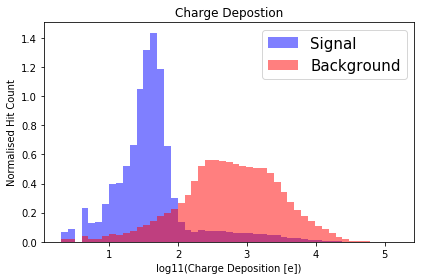

In [18]:
bins_for_plots = 50
plot_feature( np.log10(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name] + 1), 
              np.log10(train_s.cdc.get_background_hits()[train_s.cdc.edep_name] + 1), 
              xlabel="log11(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion",
              nbins=bins_for_plots)
show()

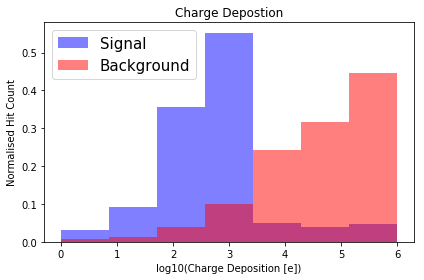

In [19]:
bins_for_plots = 50
powered_bins = np.array([3.150, 
                         10.000, 31.50,
                         100.00, 315.0,
                         1000.0])
plot_feature( np.digitize(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              np.digitize(train_s.cdc.get_background_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=7,
              uniform_bins=False)
show()

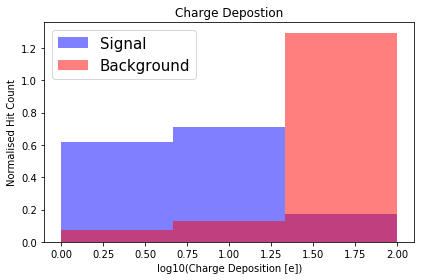

In [20]:
bins_for_plots = 50
powered_bins = np.array([31.5, 100])
plot_feature( np.digitize(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              np.digitize(train_s.cdc.get_background_hits()[train_s.cdc.edep_name], 
                          bins=powered_bins),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=3,
              uniform_bins=False,
              override_bins=None)
show()

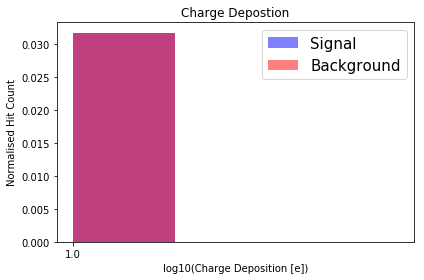

In [21]:
bins_for_plots = 50
powered_bins = np.array([0.0, 31.5, 100])
plot_feature( train_s.cdc.get_signal_hits()[train_s.cdc.edep_name],
              train_s.cdc.get_background_hits()[train_s.cdc.edep_name], 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=True,
              title="Charge Depostion", 
              nbins=10,
              uniform_bins=True,
              override_bins=powered_bins)
show()

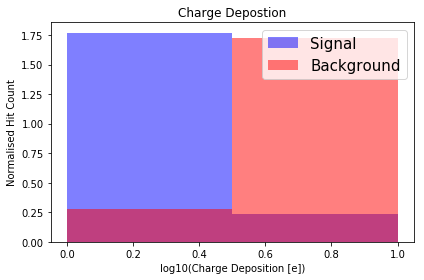

In [22]:
bins_for_plots = 50
plot_feature( np.digitize(np.log10(train_s.cdc.get_signal_hits()[train_s.cdc.edep_name] ), 
                          bins=[2]),
              np.digitize(np.log10(train_s.cdc.get_background_hits()[train_s.cdc.edep_name] ), 
                          bins=[2]),
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=2,
              uniform_bins=False)
show()

In [23]:
print(recbe_positions)

[( 0,   0,   0, 0,  0,  2) ( 0,   1,   0, 0,  0,  1)
 ( 0,   2,   0, 0,  0,  3) ... (17, 297, 103, 5, 17, 43)
 (17, 298, 103, 5, 17, 45) (17, 299, 103, 5, 17, 47)]


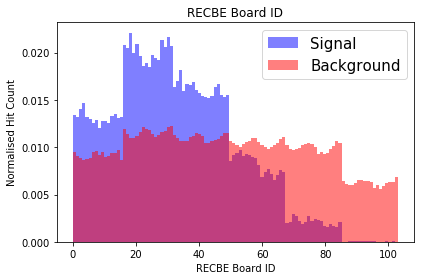

In [24]:
bins_for_plots = 50
powered_bins = np.array([31.5, 100])
plot_feature(recbe_positions["BoardID"][train_s.cdc.get_signal_hits()[train_s.cdc.flat_name]],
             recbe_positions["BoardID"][train_s.cdc.get_background_hits()[train_s.cdc.flat_name]], 
              xlabel="RECBE Board ID", ylabel="Normalised Hit Count", 
              xlog=False,
              title="RECBE Board ID", 
              nbins=104,
              uniform_bins=False)
show()

Sig Occ: 84.6103981573 , Back Occ : 610.998683778
All Occ: 695.609081935, 0.155200598379
NumHits: 695.609081935
MinChansMultiHit: 0.0


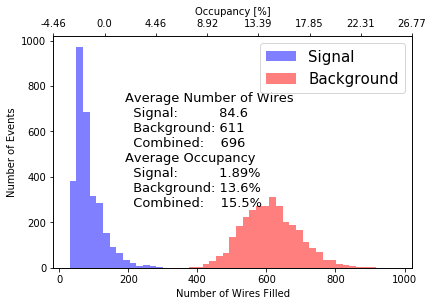

In [25]:
sig_occ, back_occ, occ = data_get_occupancy(test_s.cdc) 
plot_occupancies(sig_occ, back_occ, occ, x_pos=0.2, y_pos=0.76)

## Define Wire Features 

In [27]:
from collections import OrderedDict
from sklearn.ensemble import GradientBoostingClassifier
from pandas import DataFrame
from sklearn.metrics import roc_auc_score, roc_curve

In [30]:
# Define Data
energy_feature = "Energy"
binary_energy = energy_feature + "_one_bit"
binned_energy = energy_feature+ "_two_bit"
high_bin_energy = energy_feature+ "_three_bit"
energy_feature = energy_feature + "_unbin"
board_id = "RECBE_id"
board_layer = "RECBE_layer"
layer_id = "Layer_ID"

binary_wire_features = [binary_energy, 
                        binary_energy + "_left",
                        binary_energy + "_right"]
binned_wire_features = [binned_energy, 
                        binned_energy + "_left",
                        binned_energy + "_right"]
high_bin_wire_features = [high_bin_energy, 
                          high_bin_energy + "_left",
                          high_bin_energy + "_right"]
unbin_wire_features = [energy_feature, 
                       energy_feature + "_left",
                       energy_feature + "_right"]
all_features = binary_wire_features + \
               binned_wire_features + \
               high_bin_wire_features + \
               unbin_wire_features + \
               [board_id, board_layer, layer_id]

In [31]:
factory = OrderedDict()

# Define GBDT for ADC
binary_energy = (GradientBoostingClassifier(n_estimators=100), 
                [energy_feature])

factory['ADC'] = binary_energy
# Define GBDT for 1 bits
binary_neighs = (GradientBoostingClassifier(n_estimators=100), 
                 binary_wire_features + [board_id])
factory['Binary'] = binary_neighs
# Define GBDT for 2 bits
binned_neighs = (GradientBoostingClassifier(n_estimators=100), 
                 binned_wire_features + [board_id])
factory['Binned'] = binned_neighs
# Define GBDT for 2 bits
high_binned_neighs = (GradientBoostingClassifier(n_estimators=100), 
                      high_bin_wire_features + [board_id])
factory['High_Binned'] = high_binned_neighs
# Define GBDT over unbinned wire features
unbin_neighs = (GradientBoostingClassifier(n_estimators=100), 
                unbin_wire_features + [layer_id])
factory['Unbinned'] = unbin_neighs

In [32]:
print(train_s.cdc.n_hits, train_s.cdc.n_events)
print(train_s.cdc.get_measurement(train_s.cdc.hit_type_name).shape)

(2110668, 3039)
(2110668,)


In [33]:
def get_data_frame(samp, events):
    flat_ids = samp.cdc.get_measurement(samp.cdc.flat_name, events=events).astype(int)
    return DataFrame(np.vstack(
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[100], default=1) +\
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[1, 31.5, 100], 
                                                      default=0) +\
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events,
                                                      digitize=True, bins=[1.0000, 3.150, 
                                                                           10.000, 31.50,
                                                                           100.00, 315.0,
                                                                           1000.0], 
                                                      default=0) +\
                   data_get_measurment_and_neighbours(samp.cdc, samp.cdc.edep_name, events) +\
                        [recbe_positions["BoardID" ][flat_ids]] +\
                        [recbe_positions["BrdLayID"][flat_ids]] +\
                        [samp.cdc.geom.get_layers(flat_ids)]).T, columns=all_features)

In [54]:
# Train the classifier
train_bbdt_data = get_data_frame(train_s, evt_samp[0])
train_bbdt_target = train_s.cdc.data[train_s.cdc.hit_type_name][hit_masks[0]]

In [37]:
for classifier, features in factory.values():
    classifier.fit(train_bbdt_data[features], train_bbdt_target)

In [57]:
# Test the classifier
test_bbdt_data = get_data_frame(test_s, test_s_evt_samp[0])

In [59]:
bbdt_diagnostics = OrderedDict()
for name, (classifier, features) in factory.items():
    bbdt_diagnostics[name] = classifier.predict_proba(test_bbdt_data[features])
test_bbdt_target = test_s.cdc.data[test_s.cdc.hit_type_name][test_s_hit_masks[0]]

## Plot the Results

In [165]:
fig_scale = 2
figsize(6*fig_scale, 4*fig_scale)

save_plots = True
dpi_plots = 300
savedir = "/home/five4three2/development/ICEDUST/track-finding-yandex/images/Microsoft_AI_portfolio/"
plot_set_font()


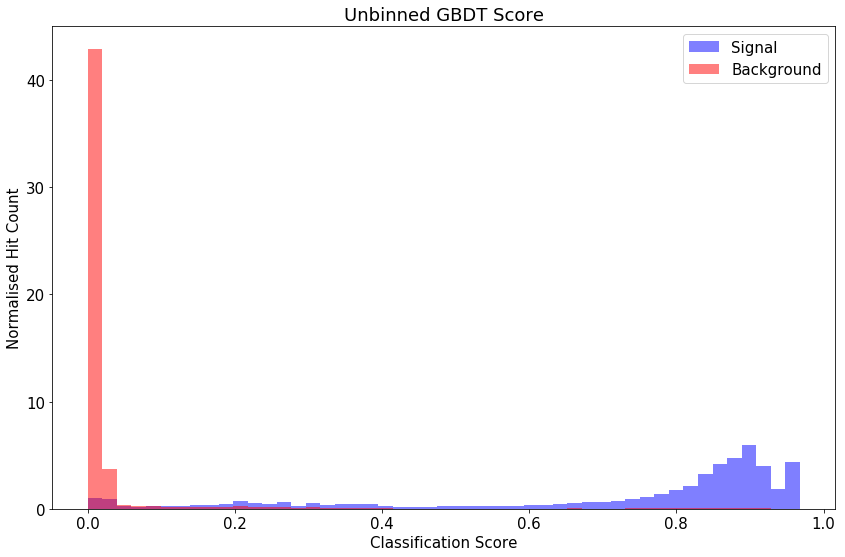

In [87]:
bins_for_plots = 50
plot_feature( bbdt_diagnostics["Unbinned"][:,1][test_bbdt_target == 1],
              bbdt_diagnostics["Unbinned"][:,1][test_bbdt_target == 0],
              xlabel="Classification Score", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Unbinned GBDT Score", 
              nbins=bins_for_plots,
              uniform_bins=True)
show()

ADC
  0.895061158222
  (3, 20576)
Binary
  0.918888788057
  (3, 379)
Binned
  0.985552430789
  (3, 1125)
High_Binned
  0.985627606403
  (3, 2801)
Unbinned
  0.987364351519
  (3, 64077)
{'ADC': 0.5536546824812271,
 'Binary': 0.3951523067190363,
 'Binned': 0.6389968013833092,
 'High_Binned': 0.6409134166212443,
 'Unbinned': 0.6861614915435258}


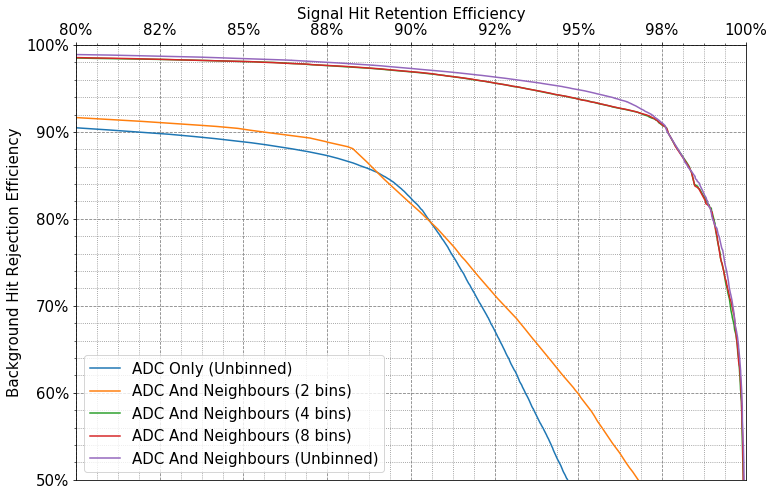

In [224]:
curve_dict = dict()

cla_dict = {}
cla_dict["ADC"] = "ADC Only (Unbinned)"
cla_dict["Binary"] = "ADC And Neighbours (2 bins)"
cla_dict["Binned"] = "ADC And Neighbours (4 bins)"
cla_dict["High_Binned"] = "ADC And Neighbours (8 bins)"
cla_dict["Unbinned"] = "ADC And Neighbours (Unbinned)"
threshold_dict = {}


for cla in bbdt_diagnostics.keys():
    pred = None
    if cla == "ADC":
        pred =  1/np.log10(1+test_s.cdc.get_measurement(test_s.cdc.edep_name, events=test_s_evt_samp[0]))
    else:
        pred = bbdt_diagnostics[cla][:,1]
    plot_roc_curve(test_bbdt_target, 
                   pred,
                   label=cla_dict[cla],
                   zoom=True,
                   zoom_x_lims=[80,100],
                   zoom_y_lims=[50,100],
                   datum_label="Hit")

    print(cla)
    print("  {}".format(roc_auc_score(test_bbdt_target, pred)))
    curve = roc_curve(test_bbdt_target, pred)
    print("  {}".format(np.array(curve).shape))
    curve_dict[cla] = curve
    threshold_dict[cla] = curve[2][np.argmin( np.abs(curve[1] - 0.80))]
if save_plots:
    plt.savefig(savedir+"roc_curves_bbdt.png", bbox_inches='tight', dpi=dpi_plots)

pprint(threshold_dict)
plt.show()

### New Plot

Need (percentage of signal hits by event,
      percentage of background hits by event,
      score) 

Have (total signal hits,
      total background hits
      score)

In [89]:
all_types = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=test_s_evt_samp[0])
beg_hits = 0
end_hits = 0

for evt in test_s_evt_samp[0]:
    end_hits += test_s.cdc.event_to_n_hits[evt]
    hit_types_1 = all_types[beg_hits:end_hits]
    hit_types_2 = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=evt)
    #print beg_hits, end_hits
    if not np.array_equal(hit_types_1, hit_types_2):
        print(evt)
        print("  {} {}".format(hit_types_1.shape, hit_types_2.shape))
        print("  {} {}".format(sum(hit_types_1 == 0.0), sum(hit_types_2 == 0.0)))
        print("  {} {}".format(sum(hit_types_1 == 1.0), sum(hit_types_2 == 1.0)))
    beg_hits += test_s.cdc.event_to_n_hits[evt]

In [90]:
all_types = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=test_s_evt_samp[0])
beg_hits = 0
end_hits = 0

for evt in test_s_evt_samp[0]:
    end_hits += test_s.cdc.event_to_n_hits[evt]
    hit_types = all_types[beg_hits:end_hits]
    same = np.array_equal(hit_types, 
                          test_s.cdc.get_measurement(test_s.cdc.hit_type_name, events=evt))
    if not same:
        print(evt, sum(hit_types==1), sum(hit_types==0), beg_hits, end_hits)
    else:
        hit_types[hit_types==1] = 1./sum(hit_types==1)
        hit_types[hit_types==0] = 1./sum(hit_types==0)
    beg_hits += test_s.cdc.event_to_n_hits[evt]

In [91]:
beg_hits = 0
end_hits = 0

for evt in test_s_evt_samp[0]:
    end_hits += test_s.cdc.event_to_n_hits[evt]
    vals, index, counts =  np.unique(all_types[beg_hits:end_hits], 
                                     return_counts=True, return_index=True)
    if np.unique(np.round(vals*counts).astype(int))[0] != 1:
        print(evt)
    beg_hits += test_s.cdc.event_to_n_hits[evt]

ADC Only (Unbinned) event weight
  0.891472200065
  (3, 27562)
ADC And Neighbours (2 bins) event weight
  0.920609921416
  (3, 379)
ADC And Neighbours (4 bins) event weight
  0.985055226246
  (3, 1125)
ADC And Neighbours (8 bins) event weight
  0.985163333043
  (3, 2845)
ADC And Neighbours (Unbinned) event weight
  0.986973099741
  (3, 82465)
{'ADC': 0.5536546824812271,
 'ADC_Evt_W': 0.5495882679536371,
 'Binary': 0.3951523067190363,
 'Binary_Evt_W': 0.40630633070108446,
 'Binned': 0.6389968013833092,
 'Binned_Evt_W': 0.6364359712902609,
 'High_Binned': 0.6409134166212443,
 'High_Binned_Evt_W': 0.635404932873268,
 'Unbinned': 0.6861614915435258,
 'Unbinned_Evt_W': 0.6614868588722398}


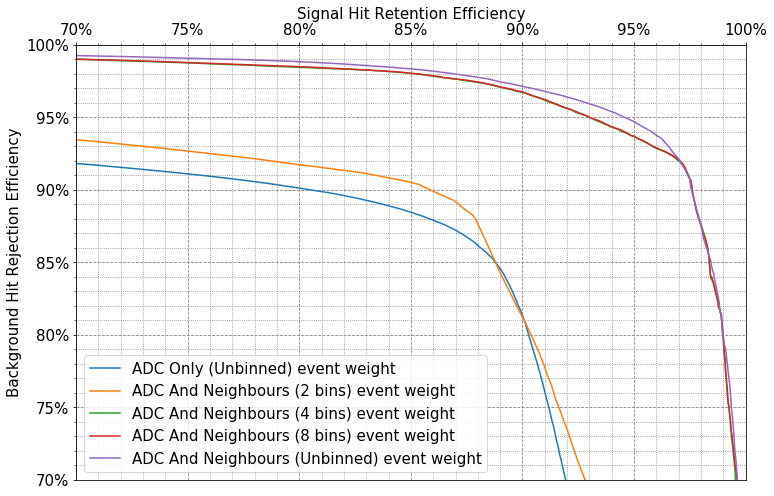

In [222]:
for cla in factory.keys():
    pred = None
    if cla == "ADC":
        pred =  1.0/np.log10(1+test_s.cdc.get_measurement(test_s.cdc.edep_name, events=test_s_evt_samp[0]))
    else:
        pred = bbdt_diagnostics[cla][:,1]
    cla_label = cla_dict[cla] + " event weight"
    plot_roc_curve(test_bbdt_target, 
                   pred,
                   label=cla_label,
                   zoom=True,
                   zoom_x_lims=[70,100],
                   zoom_y_lims=[70,100],
                   datum_label="Hit",
                   weights=all_types)

    print(cla_label)
    print("  {}".format(roc_auc_score(test_bbdt_target, pred, sample_weight=all_types)))
    curve = roc_curve(test_bbdt_target, pred, sample_weight=all_types)
    print("  {}".format(np.array(curve).shape))
    curve_dict[cla+"_Evt_W"] = curve
    threshold_dict[cla+"_Evt_W"] = curve[2][np.argmin( np.abs(curve[1] - 0.80))]

pprint(threshold_dict)
if save_plots:
    plt.savefig(savedir+"bbdt_roc_wires.png", bbox_inches='tight', dpi=dpi_plots)
plt.show()

In [93]:
#train_s.cdc.data[train_s.cdc.prefix+pos[2]] = - (train_s.cdc.data[train_s.cdc.prefix+pos[2]]/10. - 765)
#train_s.cdc.data[train_s.cdc.prefix+pos[1]] = train_s.cdc.data[train_s.cdc.prefix+pos[1]]/10.
#train_s.cdc.data[train_s.cdc.prefix+pos[0]] = (train_s.cdc.data[train_s.cdc.prefix+pos[0]]/10. - 641)
#train_s.cth.data[train_s.cth.prefix+pos[2]] = - (train_s.cth.data[train_s.cth.prefix+pos[2]]/10. - 765)
#train_s.cth.data[train_s.cth.prefix+pos[1]] = train_s.cth.data[train_s.cth.prefix+pos[1]]/10.
#train_s.cth.data[train_s.cth.prefix+pos[0]] = (train_s.cth.data[train_s.cth.prefix+pos[0]]/10. - 641)

In [94]:
pos = list()
pos += ["MCPos.fP.fX"]
pos += ["MCPos.fP.fY"]
pos += ["MCPos.fP.fZ"]

p = dict()
p["cdc"] = dict()
p["cdc"]["x"] =  train_s.cdc.prefix + pos[2]
p["cdc"]["y"] =  train_s.cdc.prefix + pos[1]
p["cdc"]["z"] =  train_s.cdc.prefix + pos[0]
p["cth"] = dict()
p["cth"]["x"] =  train_s.cth.prefix + pos[2]
p["cth"]["y"] =  train_s.cth.prefix + pos[1]
p["cth"]["z"] =  train_s.cth.prefix + pos[0]

In [121]:
high_hit = np.arange(test_s.cdc.n_events)[test_s.cdc.event_to_n_hits >= 600]
#high_hit = np.where(test_s.cdc.event_to_n_hits >= 800)[0]
n_sig = np.array([len(test_s.cdc.get_signal_hits(evt)) for evt in high_hit])
good_event = high_hit[np.logical_and(n_sig > 70, n_sig < 80)]
print(len(good_event))
print(good_event)

340
[   4   26   29   31   44   62   87  119  122  140  143  144  145  159
  171  193  196  197  200  204  215  240  243  247  300  301  317  328
  332  333  341  355  372  378  382  386  388  393  396  399  401  404
  419  421  427  438  455  458  459  462  475  476  504  506  507  522
  529  563  565  566  575  581  593  600  603  605  608  616  621  623
  635  636  642  645  675  680  681  683  689  691  702  706  707  710
  724  730  754  768  785  790  798  800  808  810  821  823  837  842
  853  858  880  892  894  904  914  917  921  922  938  949  956  971
  972  977  987  992 1003 1009 1013 1025 1072 1087 1106 1108 1127 1133
 1140 1146 1147 1159 1165 1188 1189 1197 1200 1202 1231 1235 1253 1264
 1268 1270 1271 1288 1291 1292 1324 1361 1366 1386 1402 1406 1411 1454
 1472 1475 1477 1481 1492 1500 1521 1523 1540 1546 1558 1570 1594 1596
 1602 1619 1623 1625 1636 1638 1640 1658 1659 1669 1691 1693 1697 1700
 1712 1749 1776 1787 1813 1816 1828 1836 1840 1847 1852 1870 1871 1872
 1

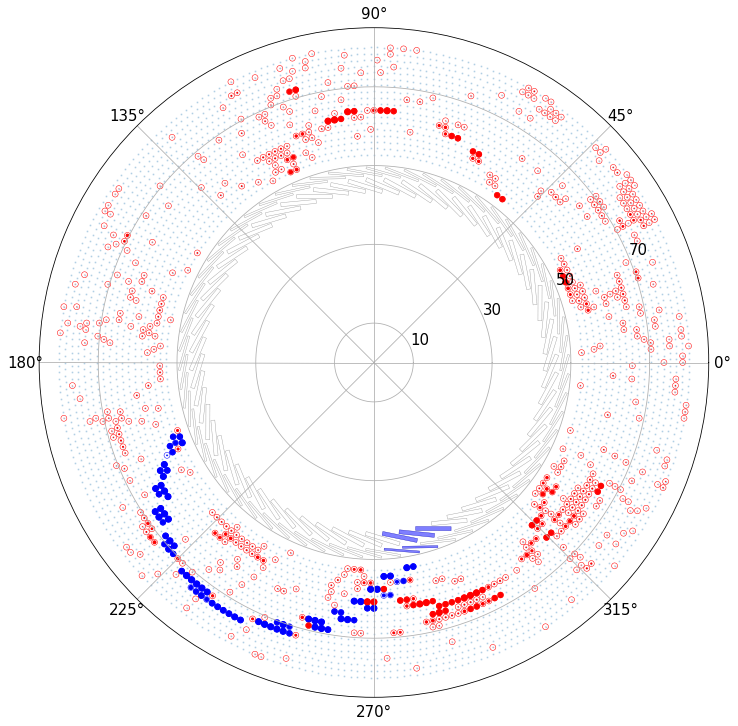

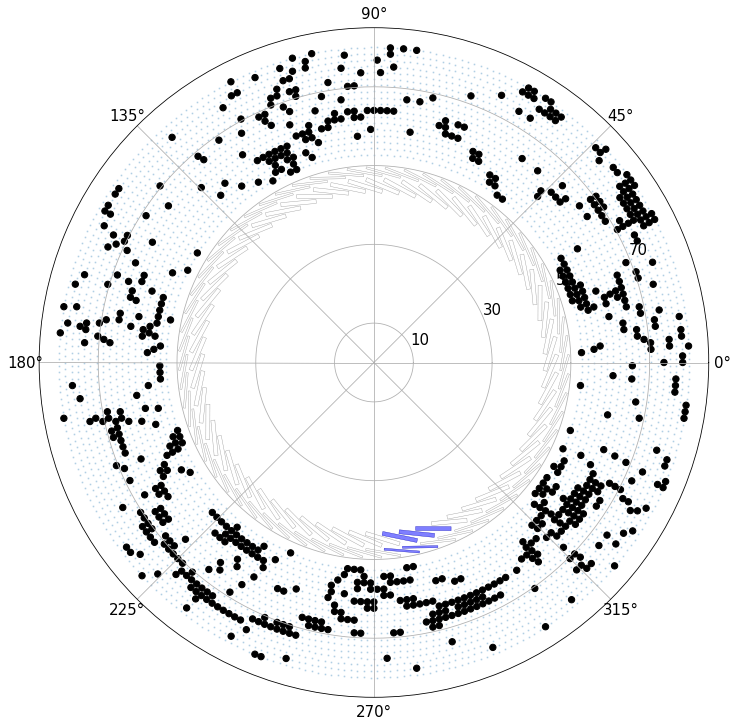

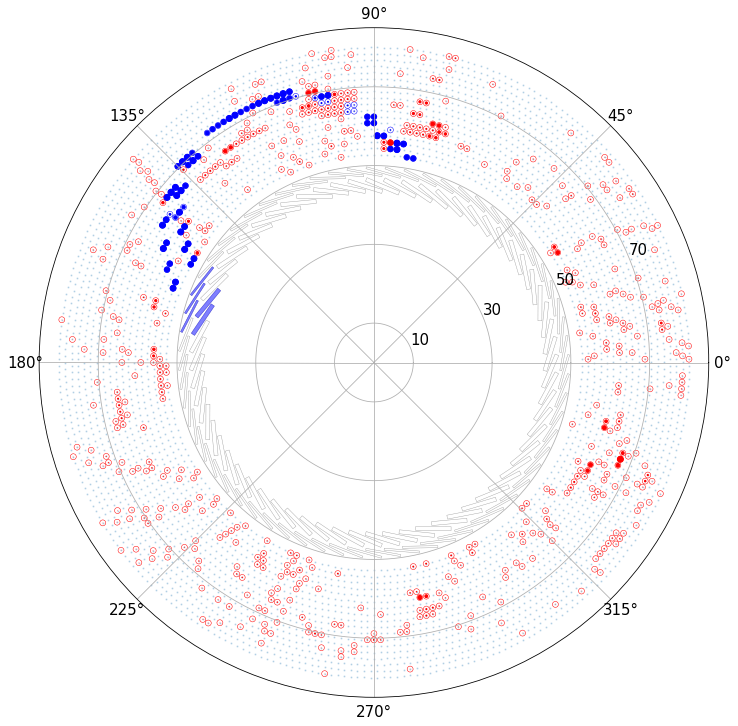

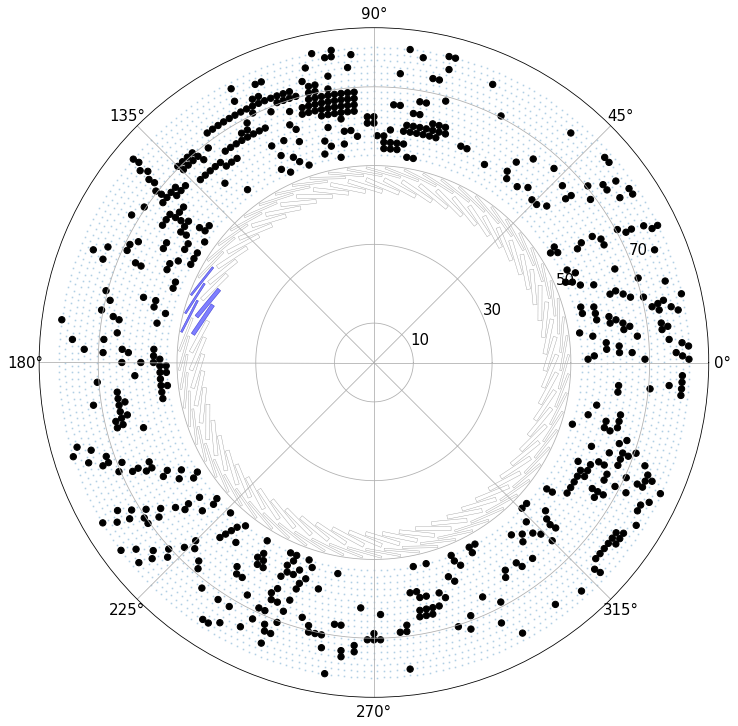

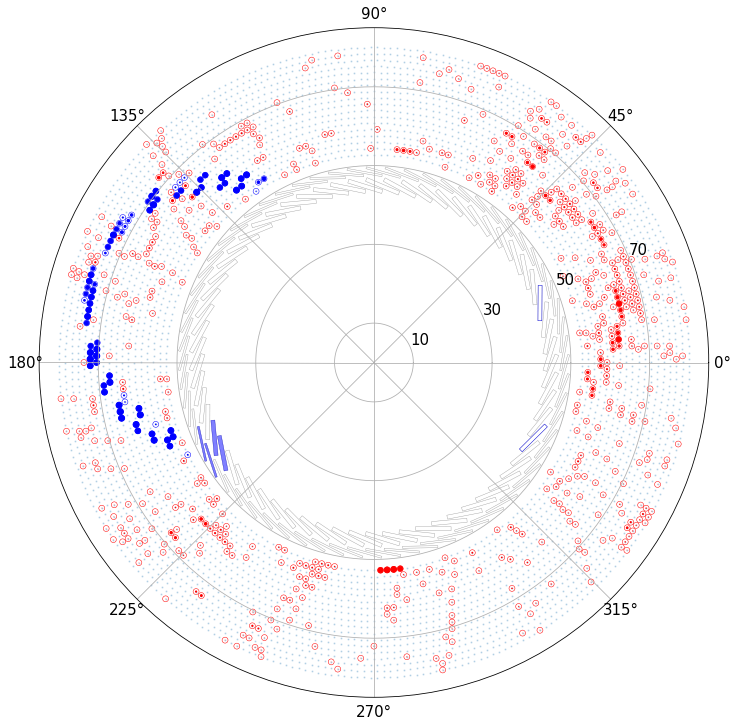

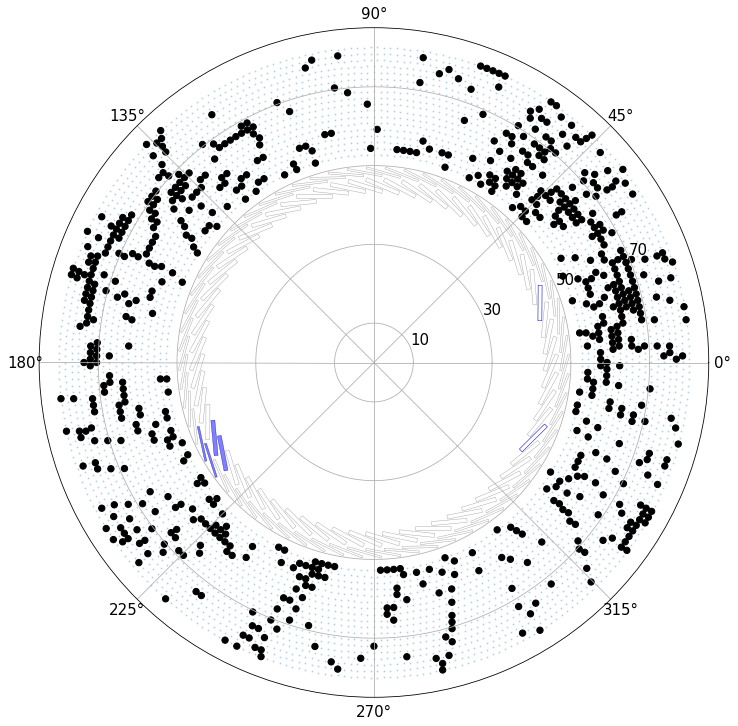

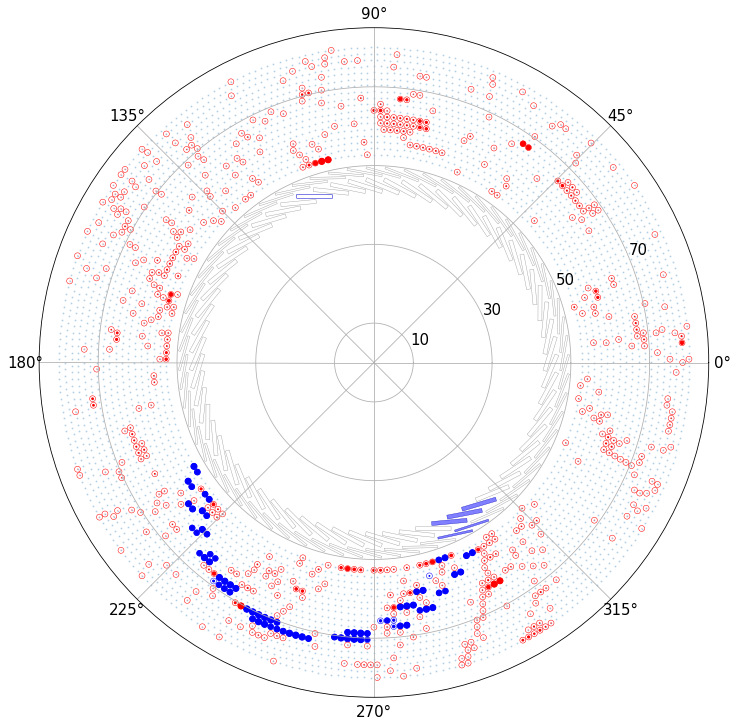

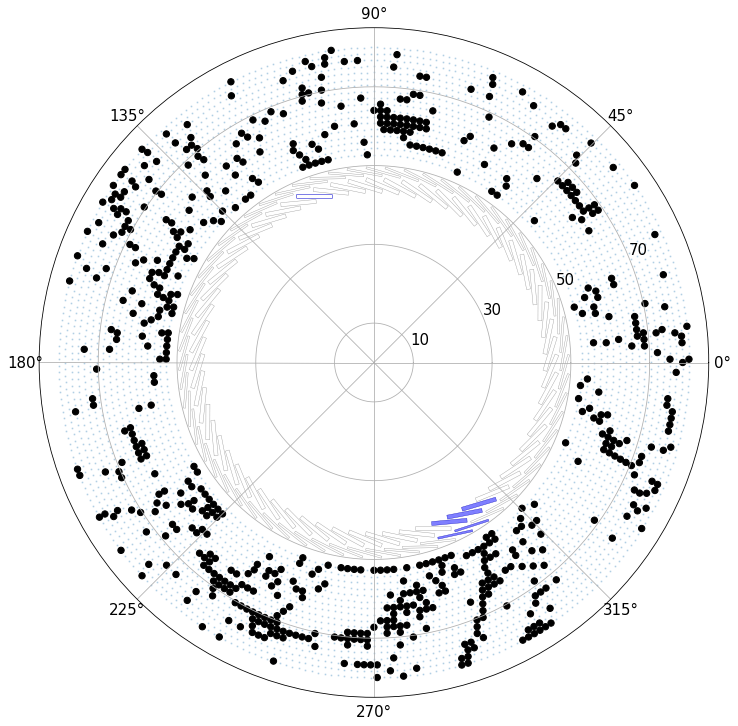

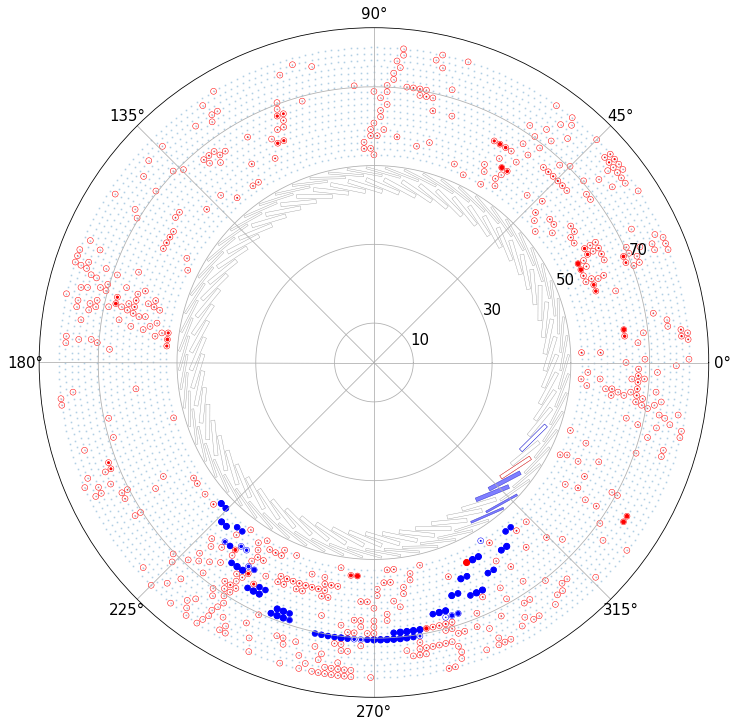

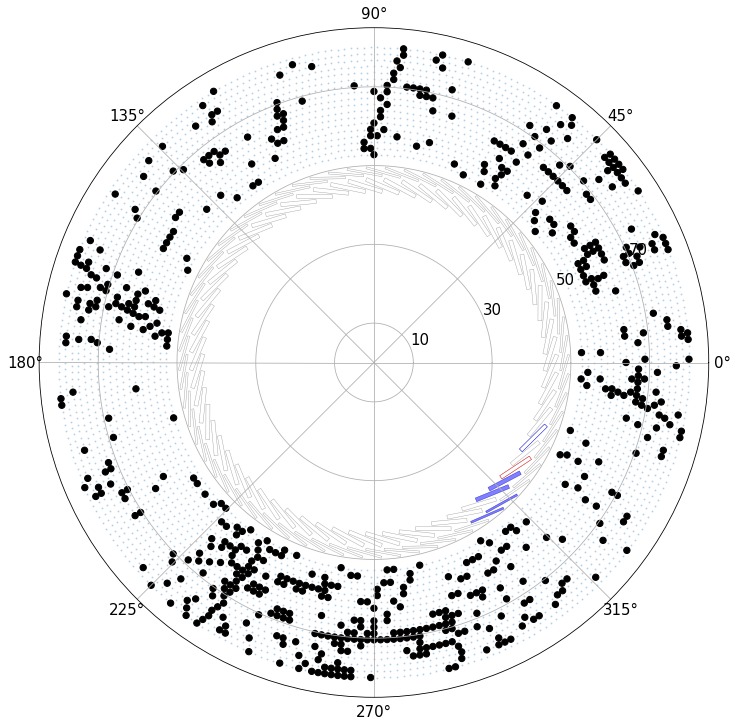

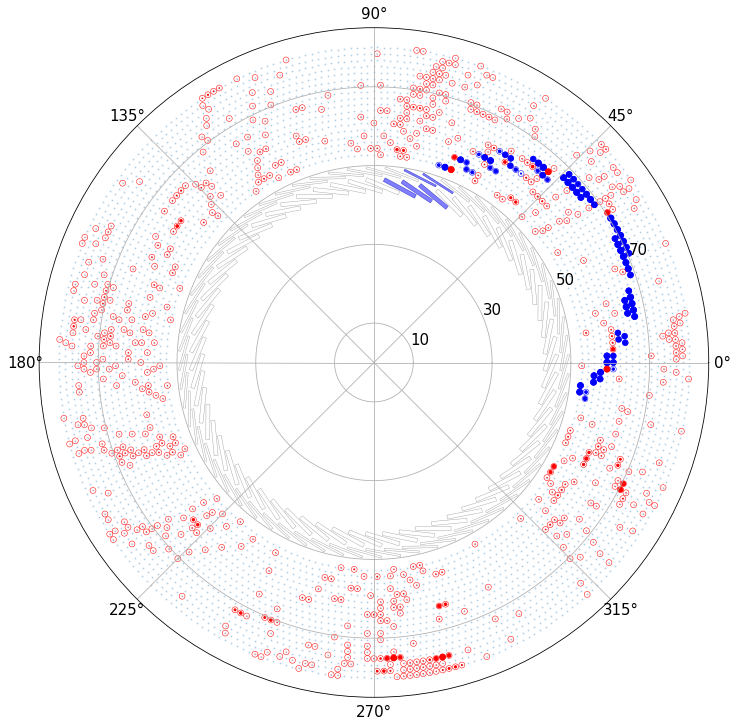

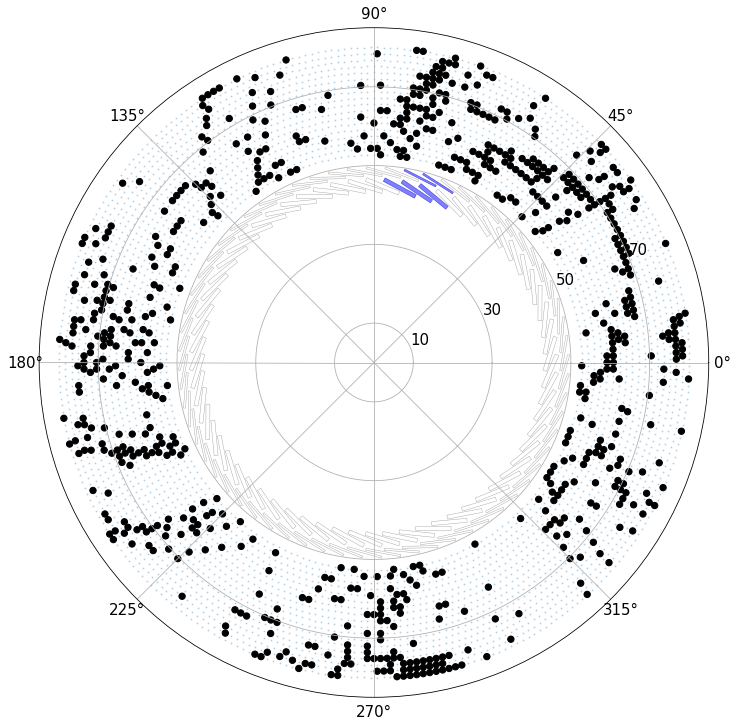

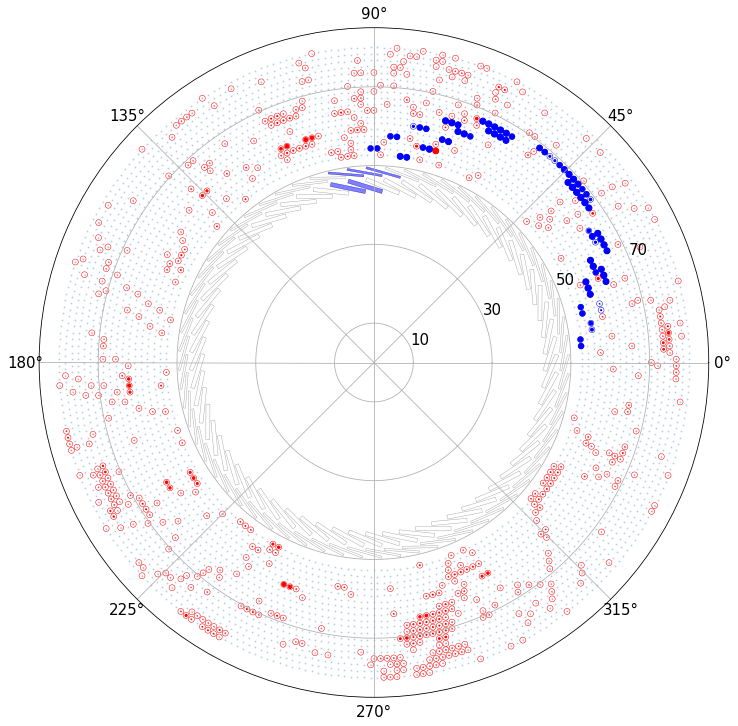

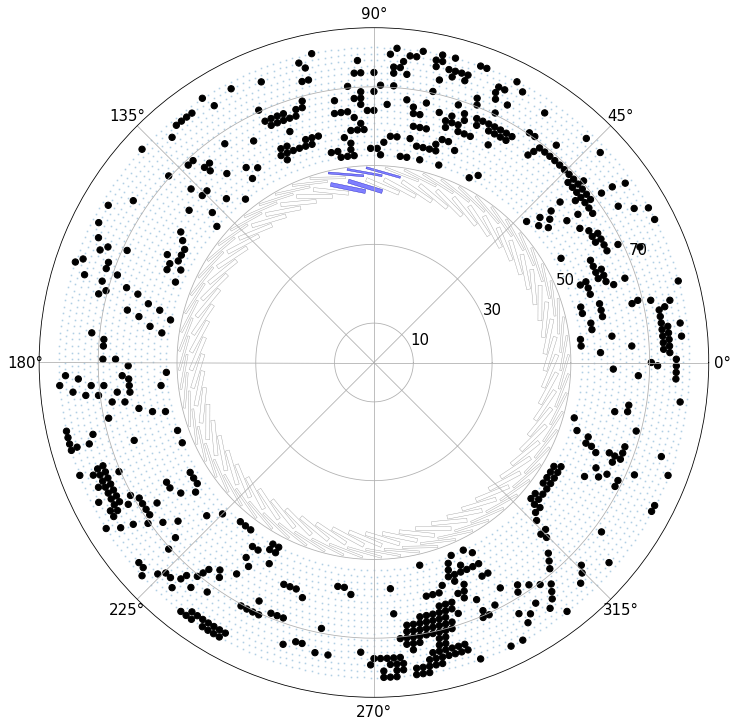

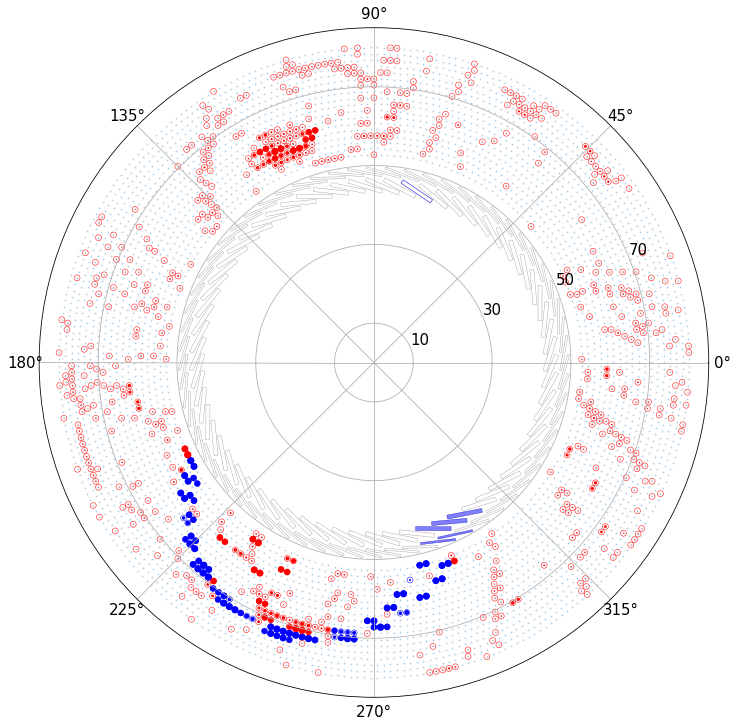

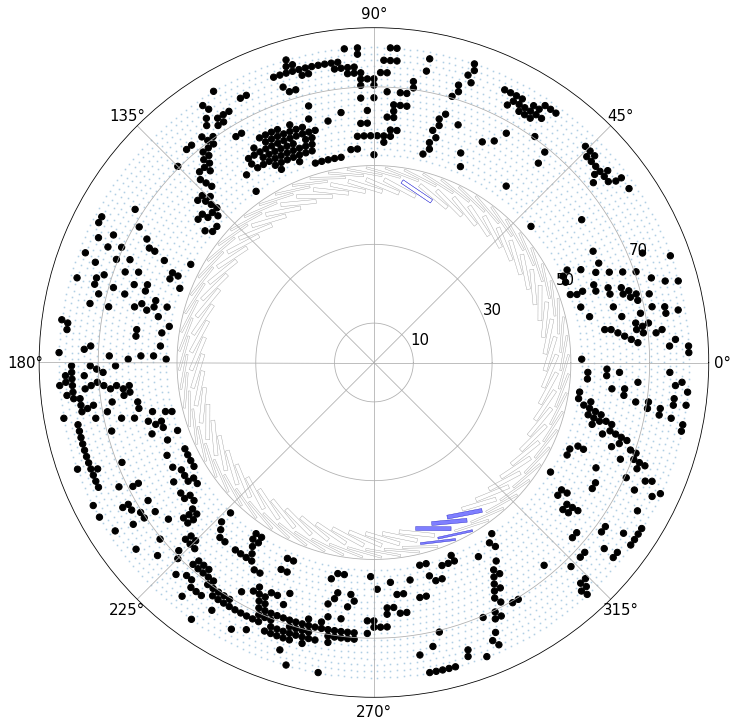

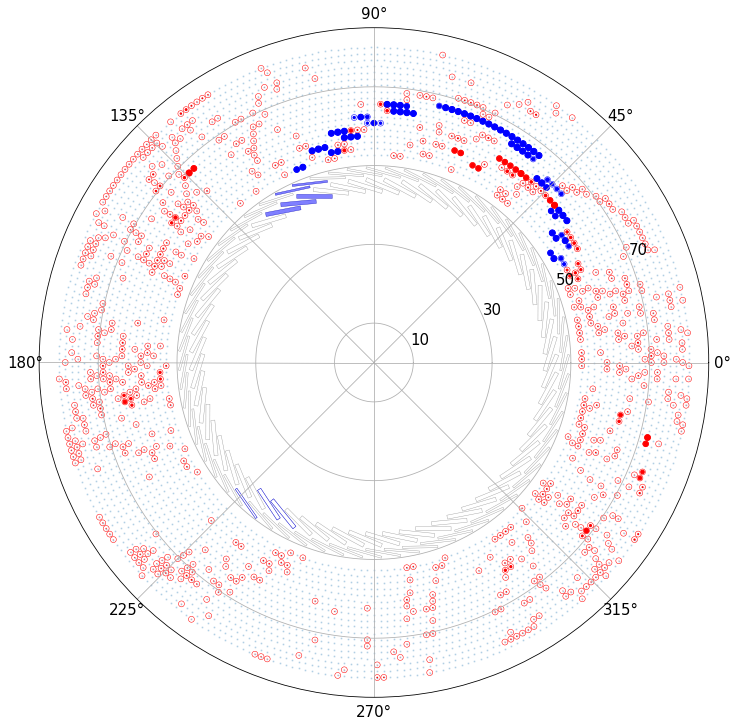

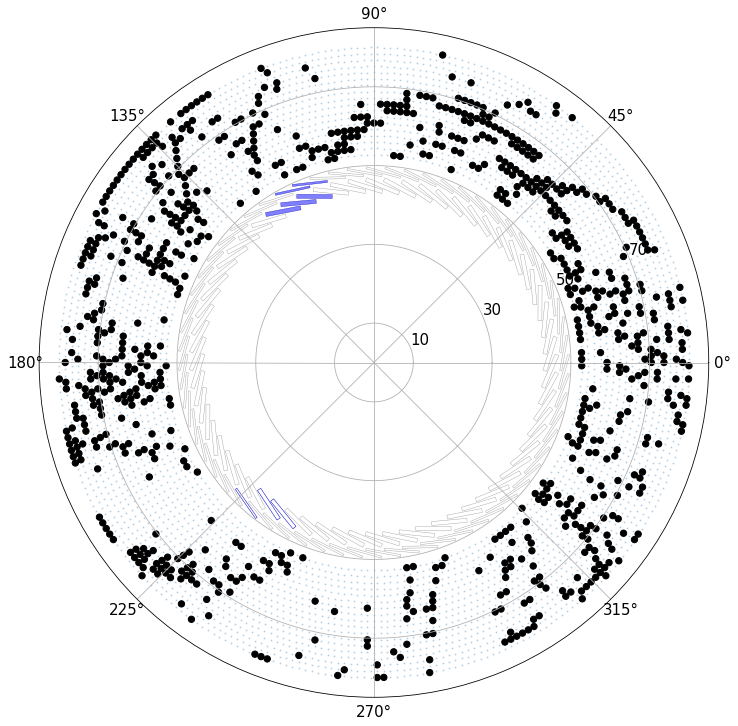

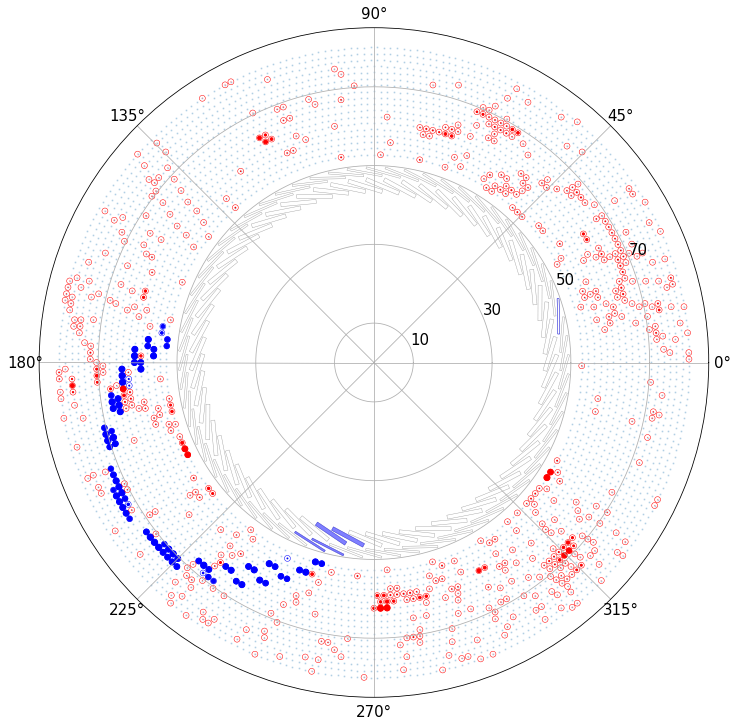

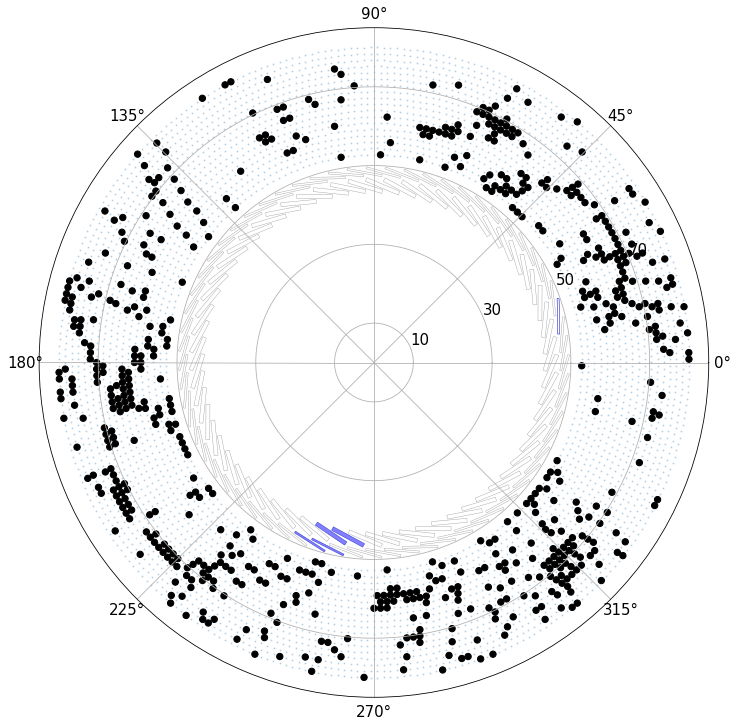

In [127]:
classifier = "Binned"
plot_recbes = True

for an_evt in range(0, 10):
    # Plot the output
    evt = good_event[an_evt]
    output = np.zeros(4482)
    geom_ids = test_s.cdc.get_measurement(test_s.cdc.flat_name, evt).astype(int)
    # Test the sample
    a_classifier, a_features = factory[classifier]
    a_data = get_data_frame(test_s, evt)[a_features]
    output[geom_ids] = a_classifier.predict_proba(a_data)[:,1]
    cut = (output >= threshold_dict[classifier])
    
    for an_output, outline in zip([output, cut], [True,False]): 
        if not outline:
            plot_output(test_s.cdc.get_hit_types(evt), test_s.cdc.geom, 
                        sig_color="Black", bkg_color="Black")
        # Add hit outlines
        if outline:
            plot_output(test_s.cdc.get_hit_types(evt), test_s.cdc.geom, 
                        size=plot_norm_size(an_output))
            plot_add_outlines(test_s.cdc.get_hit_types(evt), 
                              test_s.cdc.geom, size=s_scale)
        # Add volume outlines
        plot_add_cth_outlines(test_s.cth.geom)
        # Add the CTH vols with hits
        cth_vol_types = test_s.cth.get_vol_types(evt)
        plot_add_cth(cth_vol_types, test_s.cth.get_trig_vector(evt)[0], test_s.cth.geom)
        cth_hits = test_s.cth.get_events(evt)
        cdc_hits = test_s.cdc.get_events(evt)
        plt.scatter(cth_hits[p["cth"]["x"]], 
                    cth_hits[p["cth"]["y"]], 
                    s=1, transform=gca().transData._b)
        #plt.scatter(cdc_hits[p["cdc"]["x"]], 
        #            cdc_hits[p["cdc"]["y"]], 
        #            s=1, color="black",
        #            transform=gca().transData._b)
        plt.show()
    print("=====================================================================")

## Get board, wire mapping

In [130]:
wire_to_board = recbe_positions["BoardID"][test_s.cdc.geom.point_lookup[recbe_positions["LayerID"],
                                             recbe_positions["CellID"]]]
vals, index, inv =  np.unique(wire_to_board, 
                                 return_inverse=True, return_index=True)
board_to_wire = np.array([np.where(wire_to_board == val)[0] for val in vals])

## Examine the Boards

RECBE Level Classification:

* Features:
    * Sum of Scores (L/R)
    * Number of wires (L/R)
    * Layer ID
* Approaches:
    * Number of boards above threshold
    * Shape-based analysis
* Unused data:
    * Information from CTH trigger

## Import Event Sample

In [132]:
sig_evts = data_import_sample(signal_files[2], back_files[2], 
                              these_cuts=["Trig","Track","500"],
                              branches=these_branches)
bck_evts = data_import_sample(signal_files[2], back_files[2], 
                              these_cuts=["Trig","Track","500"],
                              branches=these_branches)

Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500',
  'CTH': '1 == 1 && 1 == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500'}
Using cuts
{ 'CDC': 'CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500',
  'CTH': 'CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1 && CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500'}
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Trimming Signal Events
CTH Sig Events 3039 
CDC Sig Events 3039 
CDC Back Events 3039 
Getting branches
{'CDC': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ'],
 'CTH': ['MCPos.fP.fX', 'MCPos.fP.fY', 'MCPos.fP.fZ']}
Using cuts
{ 'CDC': '1 == 1 && 1 == 1 && CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500',
  '

In [133]:
# Take out all signal hits fromt the background events
bck_evts.cdc.trim_hits(sig_evts.cdc.hit_type_name, values=[False])

In [134]:
sig_evts.cth.set_trigger_time()
bck_evts.cth.set_trigger_time()

In [135]:
data_remove_coincidence(sig_evts)
data_remove_coincidence(bck_evts)

### Classify Event Sample

In [136]:
evt_scores = {}
evt_scores["Signal"] = {}
evt_scores["Background"] = {}
evt_scores["Signal"]["wires"] = {}
evt_scores["Background"]["wires"] = {}
evt_scores["Signal"]["boards"] = {}
evt_scores["Background"]["boards"] = {}

In [147]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    for cla in factory.keys():
        print(etype, cla)
        a_cls, a_feat = factory[cla]
        evt_scores[etype]["wires"][cla] = \
            np.array([a_cls.predict_proba(get_data_frame(samp, evt)[a_feat])[:,1]
                      for evt in range(samp.cdc.n_events)])

('Signal', 'ADC')
('Signal', 'Binary')
('Signal', 'Binned')
('Signal', 'High_Binned')
('Signal', 'Unbinned')
('Background', 'ADC')
('Background', 'Binary')
('Background', 'Binned')
('Background', 'High_Binned')
('Background', 'Unbinned')


In [148]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    cla = "ADC_2"
    print(etype, cla)
    evt_scores[etype]["wires"][cla] = np.array([samp.cdc.get_measurement(samp.cdc.edep_name, 
                                                                         events=evt) < 100.0
                                                   for evt in range(samp.cdc.n_events)])

('Signal', 'ADC_2')
('Background', 'ADC_2')


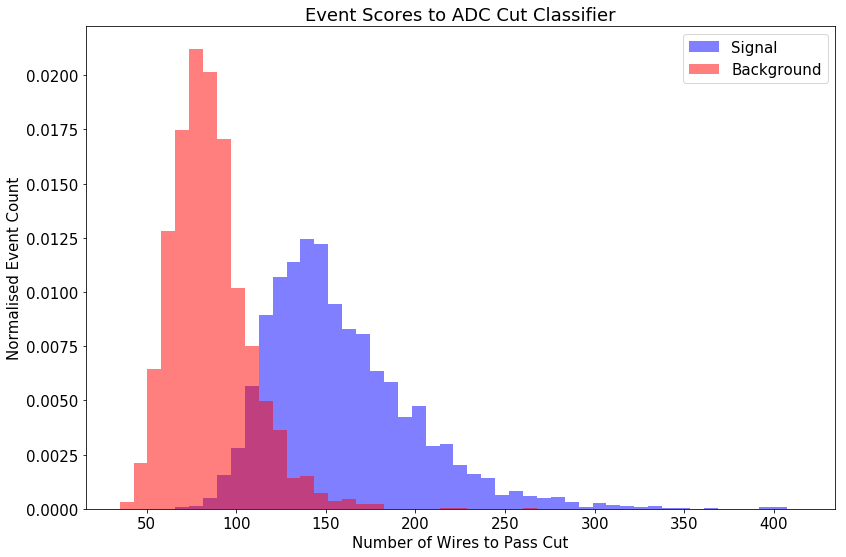

In [149]:
plot_feature( np.array([sum(score) for score in evt_scores["Signal"]["wires"]["ADC_2"]]), 
              np.array([sum(score) for score in evt_scores["Background"]["wires"]["ADC_2"]]),
              xlabel="Number of Wires to Pass Cut", ylabel="Normalised Event Count", 
              xlog=False,
              title="Event Scores to ADC Cut Classifier", 
              nbins=bins_for_plots)
plt.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f53c6d841d0>,
 <Figure size 864x576 with 1 Axes>)

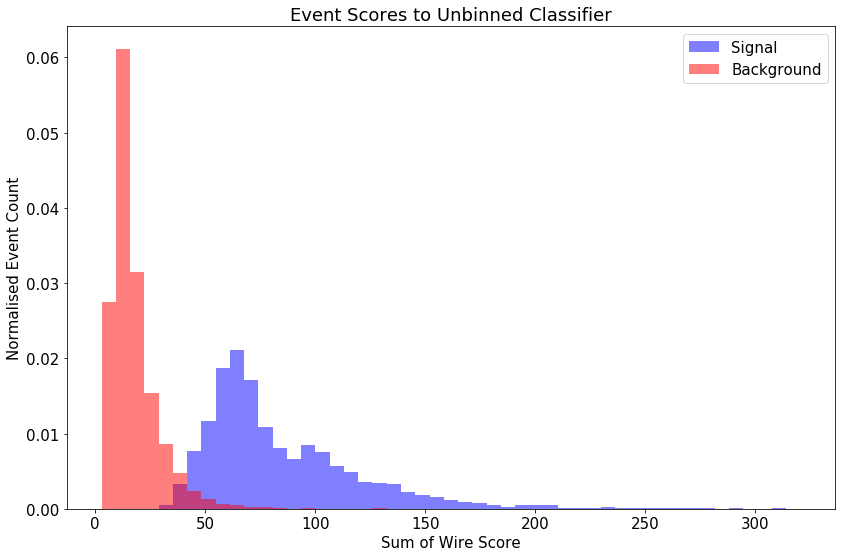

In [150]:
plot_feature( np.array([sum(score) for score in evt_scores["Signal"]["wires"]["Unbinned"]]), 
              np.array([sum(score) for score in evt_scores["Background"]["wires"]["Unbinned"]]),
              xlabel="Sum of Wire Score", ylabel="Normalised Event Count", 
              xlog=False,
              title="Event Scores to Unbinned Classifier", 
              nbins=bins_for_plots)

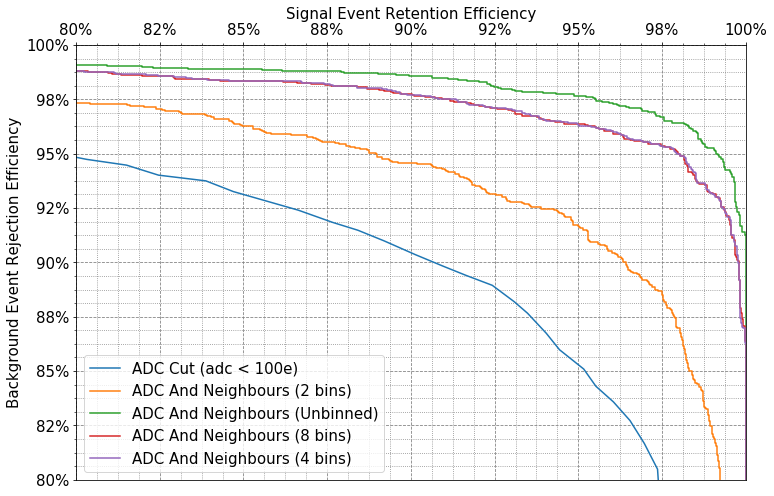

In [166]:
cla_dict["ADC_2"] = "ADC Cut (adc < 100e)"
evt_curve_dict= {}

labels = np.zeros(sig_evts.cdc.n_events + bck_evts.cdc.n_events)
labels[:sig_evts.cdc.n_events] = 1
for cla in evt_scores["Signal"]["wires"].keys():
    if cla == "ADC": continue
    sig_score = np.array([sum(score) for score in evt_scores["Signal"]["wires"][cla]])
    bkg_score = np.array([sum(score) for score in evt_scores["Background"]["wires"][cla]])
    #sig_score = sig_score/n_hits
    #bkg_score = bkg_score/n_hits
    plot_roc_curve(labels, np.append(sig_score,bkg_score),
                   label=cla_dict[cla], zoom=True,
                   zoom_x_lims=[80,100], zoom_y_lims=[80,100],
                   datum_label="Event")
    curve = roc_curve(labels, np.append(sig_score, bkg_score))
    evt_curve_dict[cla] = curve
plt.show()

## Get Board Information

In [167]:
def get_board_info(samp, samp_score, event):
    # Get the wire IDs for all the hits
    flt_ids = samp.cdc.get_measurement(samp.cdc.flat_name, events=event).astype(int)
    # Get board scores by event
    board_sum = np.zeros(board_to_wire.shape[0], dtype=float)
    brd_ids = wire_to_board[flt_ids]
    for bID, scr in zip(brd_ids, samp_score[event]):
        board_sum[bID] += scr
    # Get the number of hits per board
    brd_nhits = np.zeros_like(board_sum)
    vals, counts = np.unique(wire_to_board[samp.cdc.get_hit_vols(event)], return_counts=True)
    brd_nhits[vals] += counts    
    # Get the board labels as "has signal hit"
    brd_label = np.zeros_like(board_sum)
    brd_label[wire_to_board[samp.cdc.get_bkg_vols(event)]] = 2
    brd_label[wire_to_board[samp.cdc.get_sig_vols(event)]] = 1
    return board_sum, brd_nhits, brd_label

In [153]:
for etype, samp in zip(["Signal", "Background"],
                       [sig_evts, bck_evts]):
    for cla in evt_scores[etype]["wires"].keys():
        evt_scores[etype]["boards"][cla] = np.vstack([
            np.dstack(get_board_info(samp, evt_scores[etype]["wires"][cla], evt)) 
            for evt in range(samp.cdc.n_events)])

[0. 1. 2.]


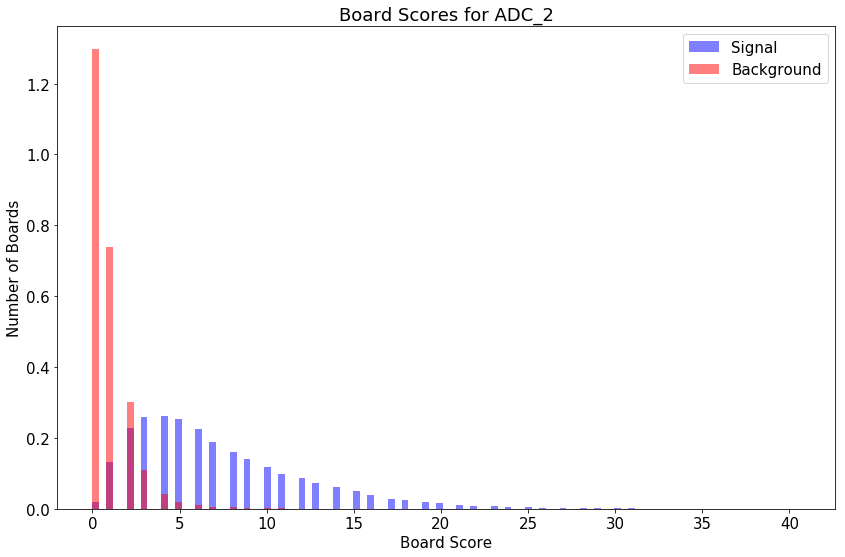

[0. 1. 2.]


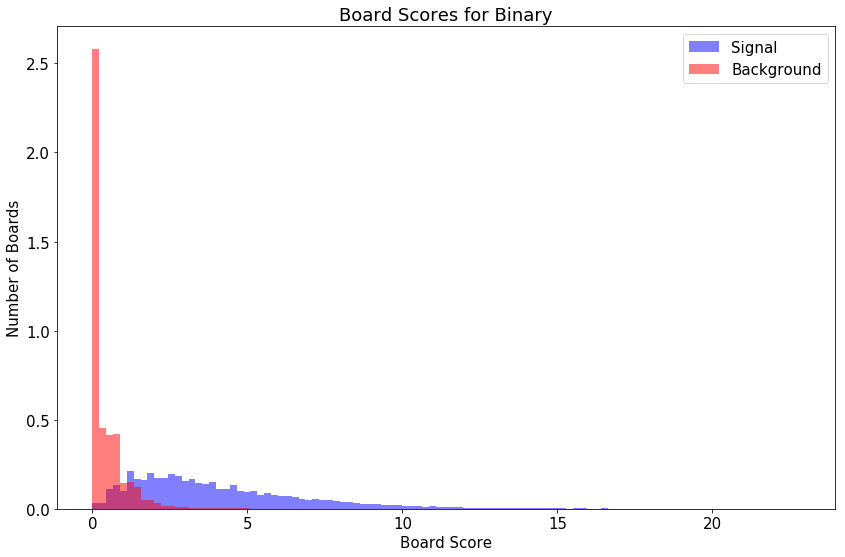

[0. 1. 2.]


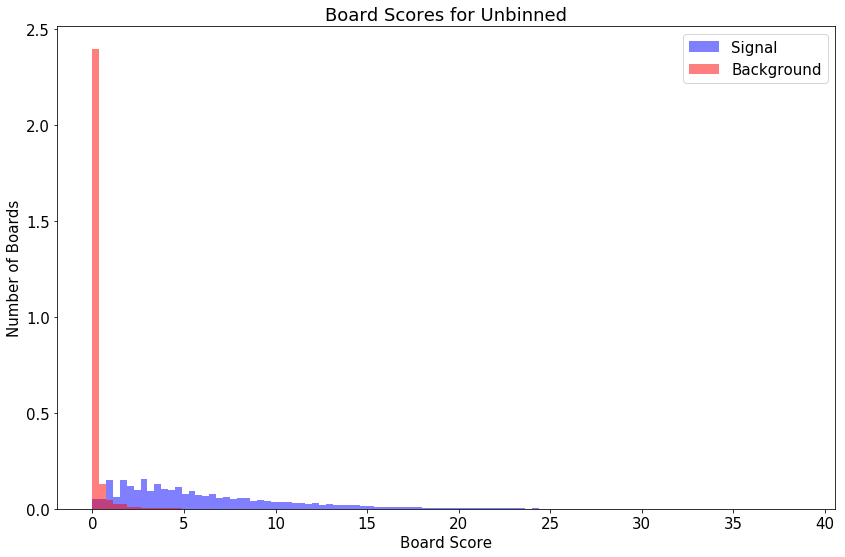

[0. 1. 2.]


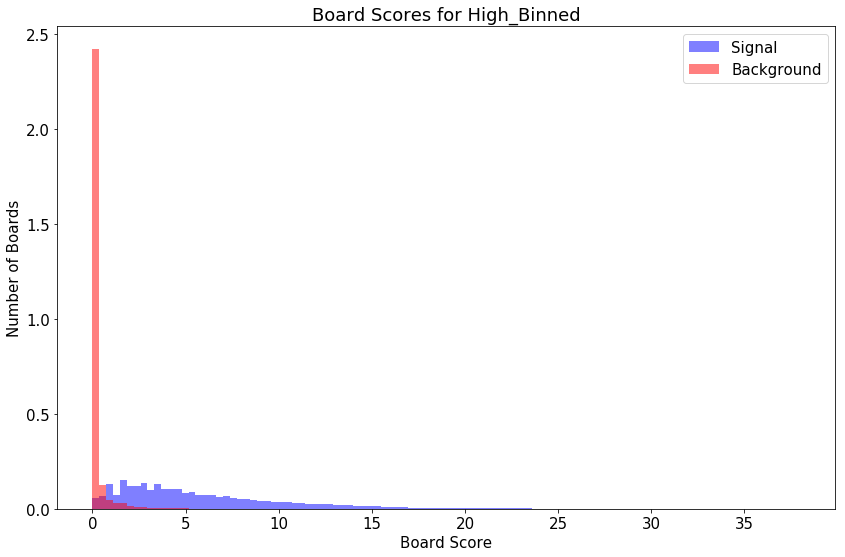

[0. 1. 2.]


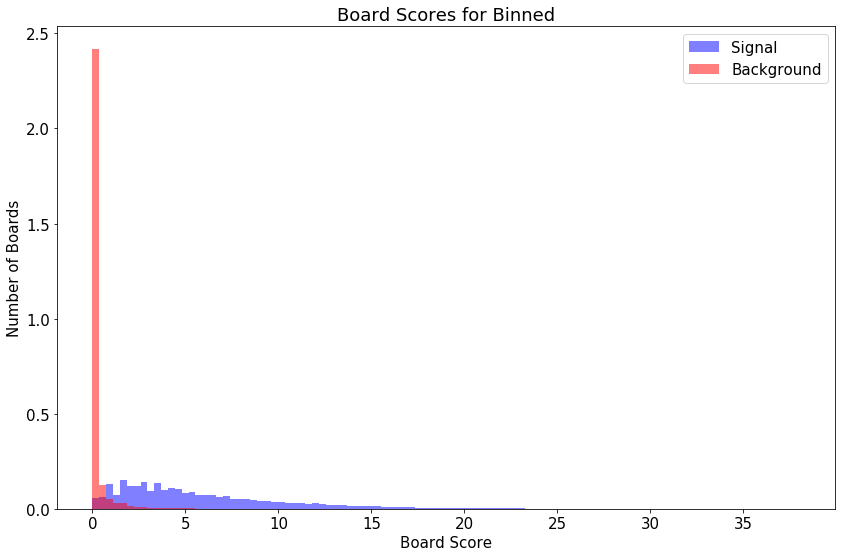

[0. 1. 2.]


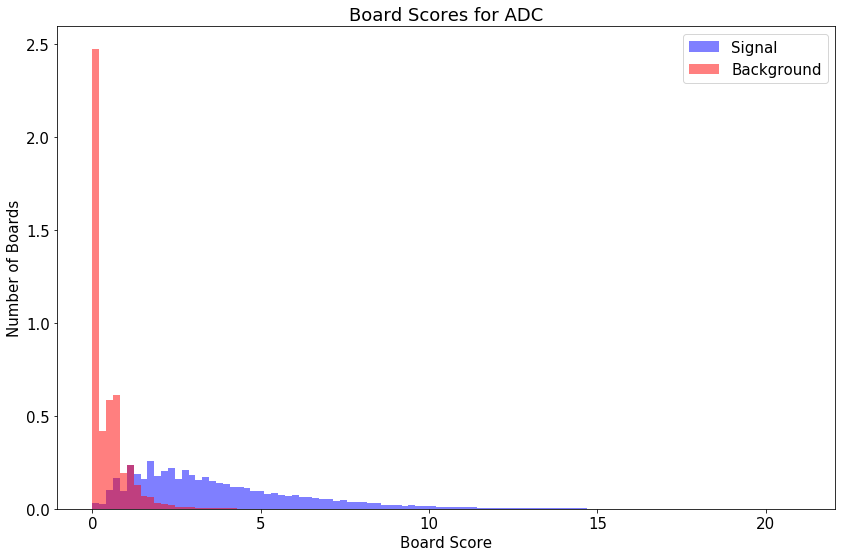

In [168]:
for cla in evt_scores["Signal"]["boards"].keys():
    board_labels = np.append(evt_scores["Signal"]["boards"][cla].reshape(-1,3)[:,2],
                             evt_scores["Background"]["boards"][cla].reshape(-1,3)[:,2])
    board_scores = np.append(evt_scores["Signal"]["boards"][cla].reshape(-1,3)[:,0],
                             evt_scores["Background"]["boards"][cla].reshape(-1,3)[:,0])
    print(numpy.unique(board_labels))
    sig_scores = board_scores[board_labels == 1]
    back_scores = board_scores[board_labels == 2]
    plot_feature( sig_scores, back_scores, 
                  xlabel="Board Score", ylabel="Number of Boards", 
                  xlog=False,
                  title="Board Scores for "+cla, 
                  nbins=104)
    plt.show()

41.0
0.9532202791139002
23.0430303699426
0.9638390152809913
39.01921134019727
0.9868329351603384
38.34748740913147
0.984625925607799
38.413307711590065
0.9845663353808631
21.216214749440084
0.9611104220227535


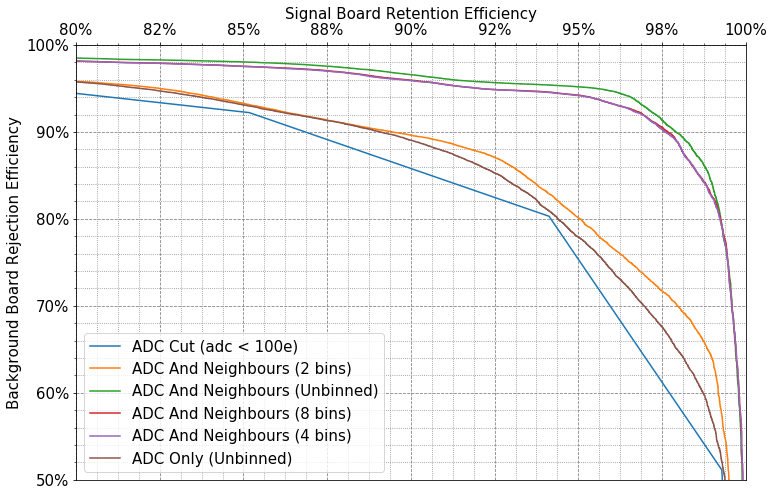

In [169]:
for cla in evt_scores["Signal"]["boards"].keys():
    board_labels = np.append(evt_scores["Signal"]["boards"][cla].reshape(-1,3)[:,2],
                             evt_scores["Background"]["boards"][cla].reshape(-1,3)[:,2])
    board_scores = np.append(evt_scores["Signal"]["boards"][cla].reshape(-1,3)[:,0],
                             evt_scores["Background"]["boards"][cla].reshape(-1,3)[:,0])
    board_nhits = np.append(evt_scores["Signal"]["boards"][cla].reshape(-1,3)[:,1],
                             evt_scores["Background"]["boards"][cla].reshape(-1,3)[:,1])
    #board_scores = board_scores/board_nhits
    print(np.amax(board_scores))
    # Get the signal and back only board scores (no empties)
    sig_scores = board_scores[board_labels == 1]
    back_scores = board_scores[board_labels == 2]
    all_scores = np.append(sig_scores, back_scores)
    labels = np.zeros_like(all_scores)
    # Label these scores
    labels[range(len(sig_scores))] = 1
    plot_roc_curve(labels, all_scores,
                   label=cla_dict[cla], zoom=True,
                   zoom_x_lims=[80,100], zoom_y_lims=[50,100],
                   datum_label="Board")
    curve = roc_curve(labels, all_scores)
    print(roc_auc_score(labels, all_scores))
    #evt_curve_dict[cla] = curve
plt.show()

## Classify Events Using Board Location Agreement

In [156]:
pos_score = dict(dict())
pos_score["Signal"] = {}
pos_score["Background"] = {}


for etype in ["Signal", "Background"]:
    all_cla = evt_scores[etype]["boards"]
    for cla in all_cla.keys():
        # Store these values in a dictionary
        pos_score[etype][cla] = np.zeros(all_cla[cla].shape[0])
        for evt_idx, evt_brds in enumerate(all_cla[cla]):
            evt_x_pos = 0.
            evt_y_pos = 0.
            for brd_id, brd in enumerate(evt_brds):
                brd_phi = np.average(sig_evts.cdc.geom.point_phis[board_to_wire[brd_id]])
                if brd[1] != 0:
                    evt_x_pos += brd[0]*np.cos(brd_phi)
                    evt_y_pos += brd[0]*np.sin(brd_phi)
            pos_score[etype][cla][evt_idx] = np.sqrt(evt_x_pos*evt_x_pos + \
                                                     evt_y_pos*evt_y_pos)

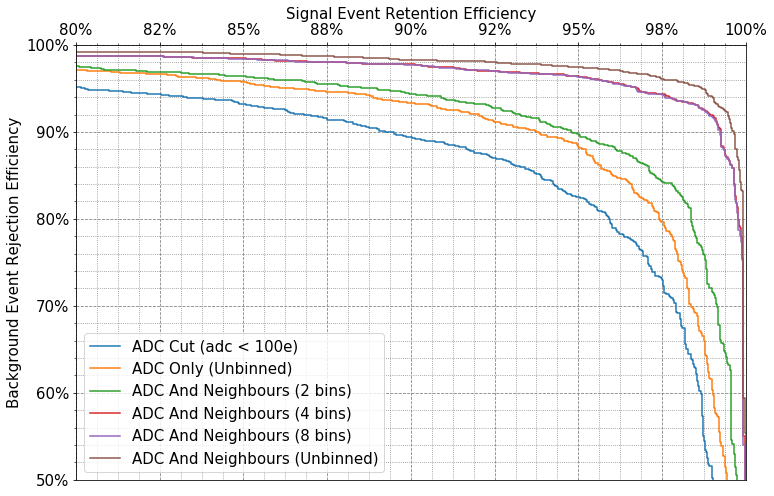

In [219]:
for cla in ["ADC_2", "ADC", "Binary", "Binned", "High_Binned", "Unbinned"]:
    sig_scores = pos_score["Signal"][cla]
    back_scores =  pos_score["Background"][cla]
    all_scores = np.append(sig_scores, back_scores)
    labels = np.zeros_like(all_scores)
    # Label these scores
    labels[range(len(sig_scores))] = 1
    plot_roc_curve(labels, all_scores,
                   label=cla_dict[cla], zoom=True,
                   zoom_x_lims=[80,100], zoom_y_lims=[50,100],
                   datum_label="Event")

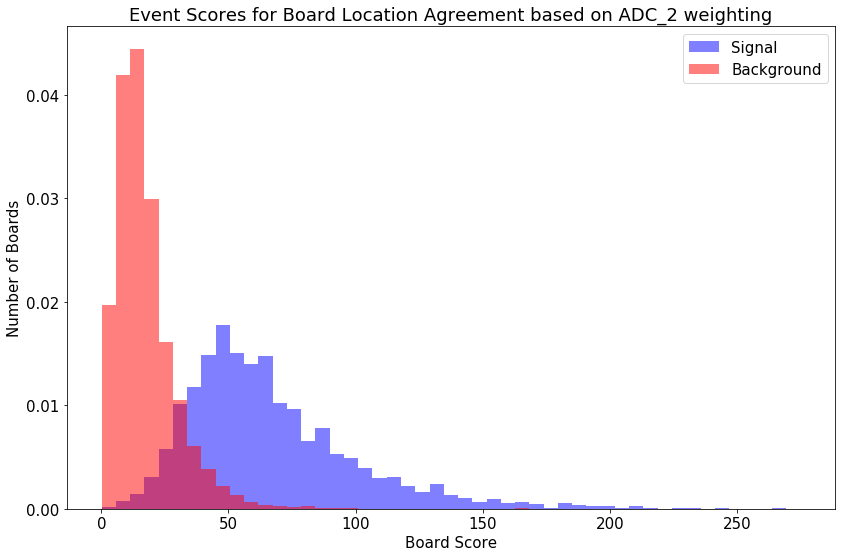

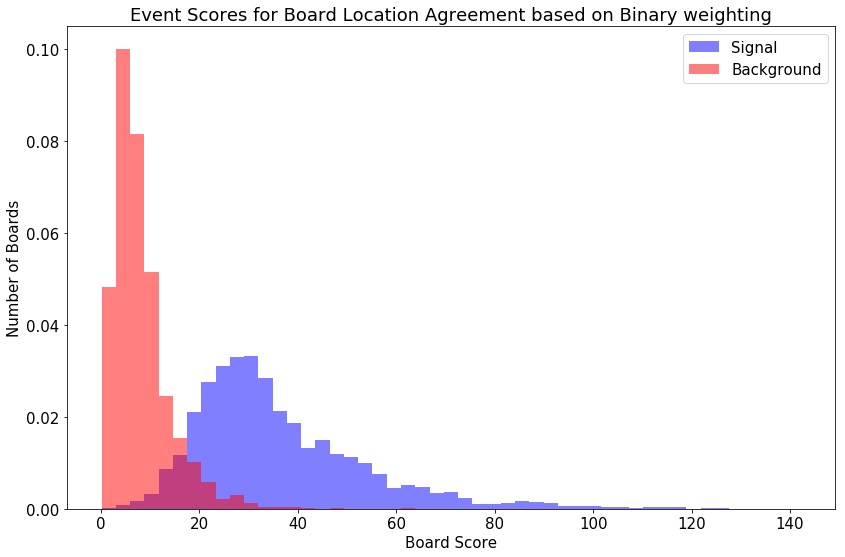

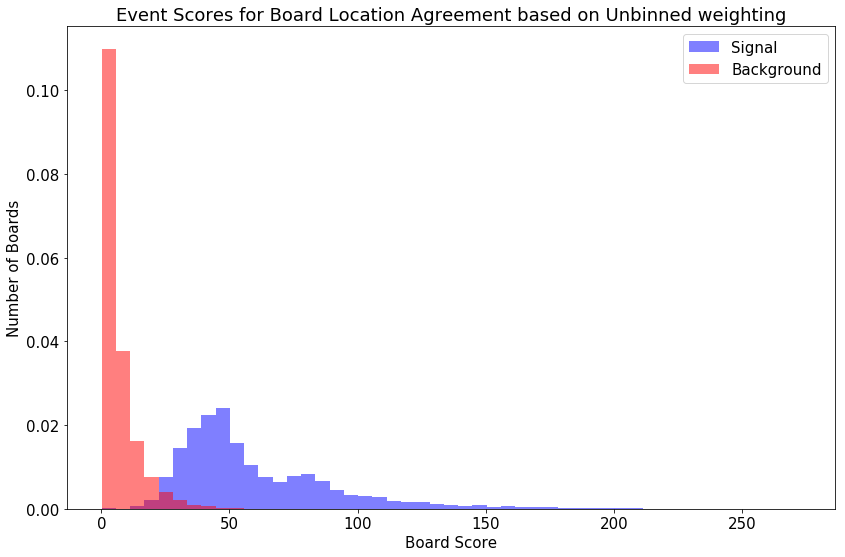

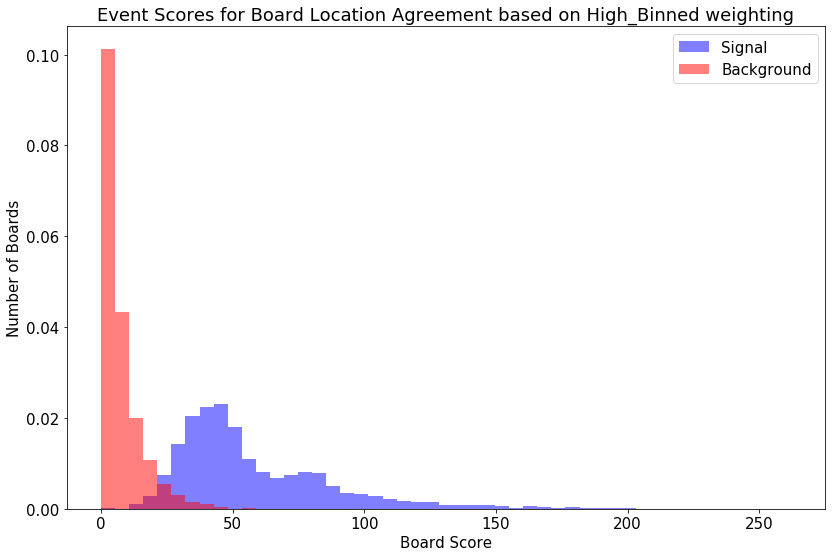

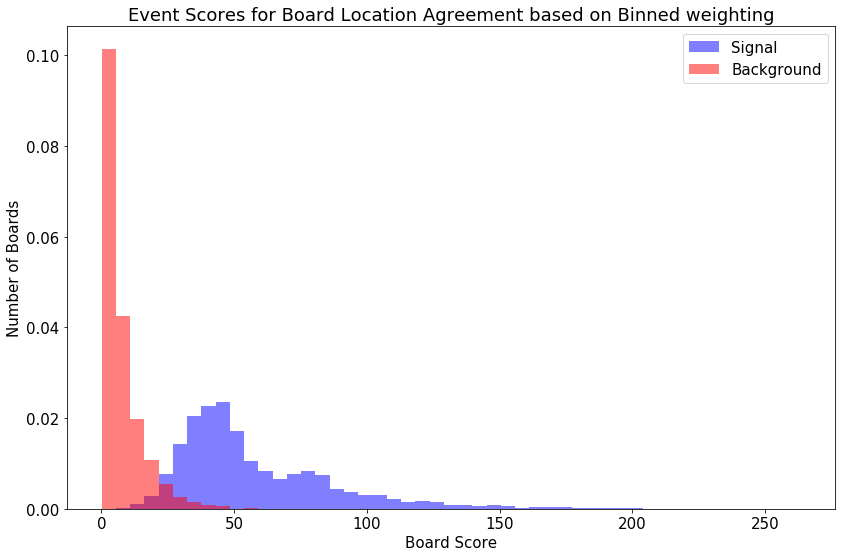

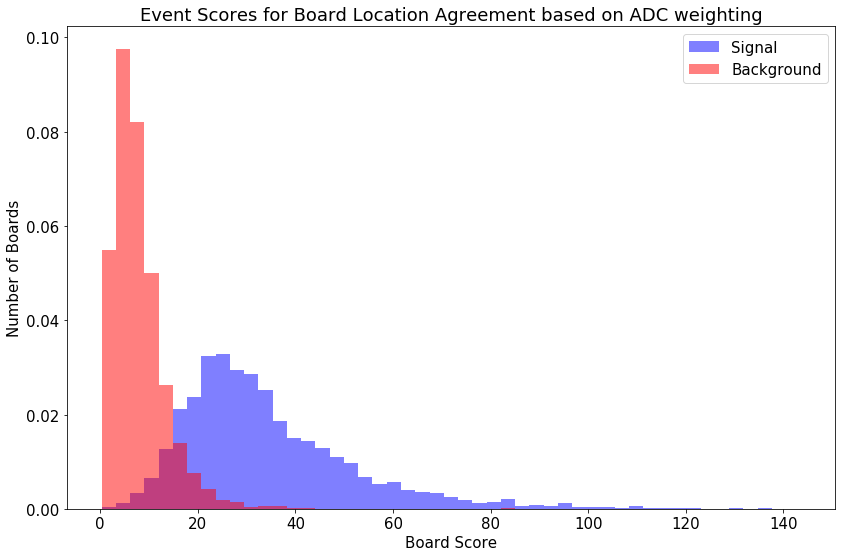

In [171]:
for cla in pos_score["Signal"].keys():
    sig_scores = pos_score["Signal"][cla]
    back_scores =  pos_score["Background"][cla]
    plot_feature( sig_scores, back_scores, 
                  xlabel="Board Score", ylabel="Number of Boards", 
                  xlog=False,
                  title="Event Scores for Board Location Agreement based on "+cla+" weighting", 
                  nbins=bins_for_plots)
    plt.show()

# Develop Board Hough

In [173]:
import cylinder
reload(cylinder)
from cylinder import RECBE, CDC
from scipy.spatial import ConvexHull

In [174]:
cydet_geom = sig_evts.cdc.geom
cydet_geom = CDC(projection=0.0)
new_recbe = RECBE(cydet_geom)
all_colour = np.linspace(0,1,104)
np.random.shuffle(all_colour)

In [175]:
evt = 10
board_info = evt_scores["Background"]["boards"]["High_Binned"][evt]
print(board_info.shape)

(104, 3)


# Hough Transform the Boards

In [176]:
import tracking
reload(tracking)

<module 'tracking' from '../modules/tracking.pyc'>

In [177]:
from tracking import HoughSpace
from scipy import sparse
from tracking import HoughTransformer, HoughShifter

In [178]:
default = [[31.5, 34, 34.5, 2]]
submatrices = []

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(sig_evts.cdc.geom.recbe, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81, split=False)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [179]:
new_correspondence.shape

(104, 2701)

In [225]:
# Fit and transform the second data sample
fit_class = evt_scores["Signal"]["boards"]["Unbinned"]
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     fit_class[:,:,0]/(fit_class[:,:,1]+1),
                                     alpha_max=2., alpha_rw=1., min_percentile=0.97)

In [230]:
pprint(cla_dict)

{'ADC': 'ADC Only (Unbinned)',
 'ADC_2': 'ADC Cut (adc < 100e)',
 'Binary': 'ADC And Neighbours (2 bins)',
 'Binned': 'ADC And Neighbours (4 bins)',
 'High_Binned': 'ADC And Neighbours (8 bins)',
 'Unbinned': 'ADC And Neighbours (Unbinned)'}


ADC_2
(1.3698897650535147, 17.597186784132298)
('ADC_2', 0.93848067694286)
('ADC_2', 0.9489951893347435)
Binary
(0.6955710656632749, 12.781587140511796)
('Binary', 0.9621564933911148)
('Binary', 0.9636493165897192)
Binned
(1.3320690707598046, 15.677245002265558)
('Binned', 0.9960604279931798)
('Binned', 0.9965665174709688)
High_Binned
(1.309197708715536, 14.615132668408208)
('High_Binned', 0.9950976777595979)
('High_Binned', 0.9958379716747978)
Unbinned
(1.3085030075994863, 14.79624245849833)
('Unbinned', 0.9951352500849708)
('Unbinned', 0.9958642831303183)


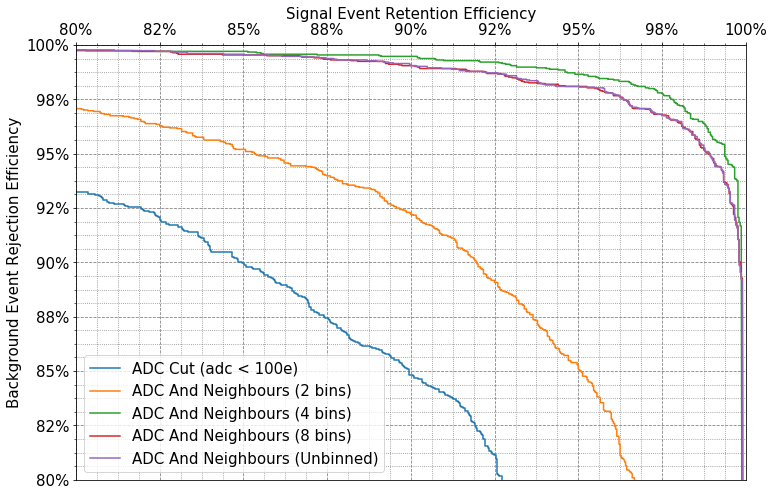

In [231]:
for sig, bkg, cla in zip(evt_scores["Signal"]["boards"].itervalues(),
                         evt_scores["Background"]["boards"].itervalues(),
                         ["ADC_2", "Binary", "Binned", "High_Binned", "Unbinned"]):
    # Labels 
    print(cla)
    labels = np.zeros(sig.shape[0] + bkg.shape[0])
    labels[:sig.shape[0]] = 1
    # Scores
    scores = np.zeros_like(labels)
    scores = np.vstack([scores,scores])
    # Signal scores
    score = sig[:,:,0]/(sig[:,:,1]+1)
    trans_data, hough_images = \
            hough_transformer.transform(score, only_hits=False, flatten=False)
    print(np.amax(trans_data), np.amax(hough_images))
    scores[0,:sig.shape[0]]  = np.sum(trans_data, axis=1)
    scores[1,:sig.shape[0]]  = np.sum(hough_images, axis=1)
    # Background scroes
    score = bkg[:,:,0]/(bkg[:,:,1]+1)
    trans_data, hough_images = \
            hough_transformer.transform(score,only_hits=False, flatten=False)
    scores[0,sig.shape[0]:]  = np.sum(trans_data, axis=1)
    scores[1,sig.shape[0]:]  = np.sum(hough_images, axis=1)
    plot_roc_curve(labels, scores[1,:],
                   label=cla_dict[cla], zoom=True,
                   zoom_x_lims=[80,100], zoom_y_lims=[80,100],
                   datum_label="Event") 
    print(cla, roc_auc_score(labels, scores[0,:]))
    print(cla, roc_auc_score(labels, scores[1,:]))
if save_plots:
    plt.savefig(savedir+"bbdt_roc_curve_event.png", bbox_inches='tight', dpi=dpi_plots)
plt.show()

In [194]:
def shift_to_detector_coords(samp):
    samp.cdc.data[samp.cdc.prefix+pos[2]] = - (samp.cdc.data[samp.cdc.prefix+pos[2]]/10. - 765)
    samp.cdc.data[samp.cdc.prefix+pos[1]] = samp.cdc.data[samp.cdc.prefix+pos[1]]/10.
    samp.cdc.data[samp.cdc.prefix+pos[0]] = (samp.cdc.data[samp.cdc.prefix+pos[0]]/10. - 641)
    samp.cth.data[samp.cth.prefix+pos[2]] = - (samp.cth.data[samp.cth.prefix+pos[2]]/10. - 765)
    samp.cth.data[samp.cth.prefix+pos[1]] = samp.cth.data[samp.cth.prefix+pos[1]]/10.
    samp.cth.data[samp.cth.prefix+pos[0]] = (samp.cth.data[samp.cth.prefix+pos[0]]/10. - 641)

In [232]:
#shift_to_detector_coords(sig_evts)
#shift_to_detector_coords(bck_evts)

In [197]:
print np.amax(hough_images)

6.6447443227657


In [201]:
high_hit = np.arange(sig_evts.cdc.n_events)[sig_evts.cdc.event_to_n_hits >= 600]
#high_hit = np.where(test_s.cdc.event_to_n_hits >= 800)[0]
n_sig = np.array([len(sig_evts.cdc.get_signal_hits(evt)) for evt in high_hit])
good_event = high_hit[np.logical_and(n_sig > 70, n_sig < 80)]
print(len(good_event))
print(good_event)

325
[   8   24   49   61   66   68   73   75   76   79   94  104  119  134
  155  156  167  171  177  186  199  200  202  203  206  224  252  271
  284  315  317  332  341  343  347  353  380  389  393  399  413  428
  430  487  489  523  526  546  550  556  561  587  588  589  611  620
  621  633  644  646  660  678  683  685  686  696  704  712  718  724
  726  728  734  736  742  783  790  795  798  832  838  839  840  841
  845  847  850  857  867  877  879  884  895  899  950  970  986  987
  996 1009 1013 1017 1026 1027 1030 1031 1033 1036 1037 1052 1053 1071
 1081 1088 1094 1095 1100 1106 1123 1124 1134 1135 1148 1149 1150 1162
 1164 1178 1183 1185 1186 1193 1215 1223 1228 1238 1247 1248 1256 1279
 1280 1284 1299 1303 1313 1332 1335 1347 1348 1351 1358 1360 1362 1367
 1368 1386 1397 1400 1406 1419 1423 1427 1437 1445 1449 1465 1466 1469
 1488 1489 1508 1516 1532 1556 1562 1571 1574 1581 1607 1611 1618 1632
 1664 1684 1685 1695 1698 1699 1701 1705 1708 1713 1725 1734 1736 1739
 1

/home/five4three2/development/miniconda3/envs/tfy2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


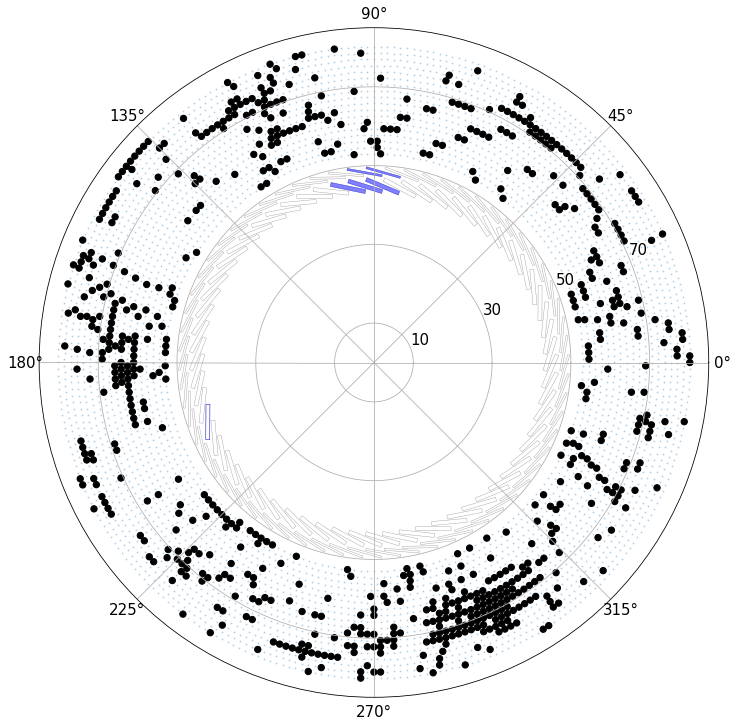

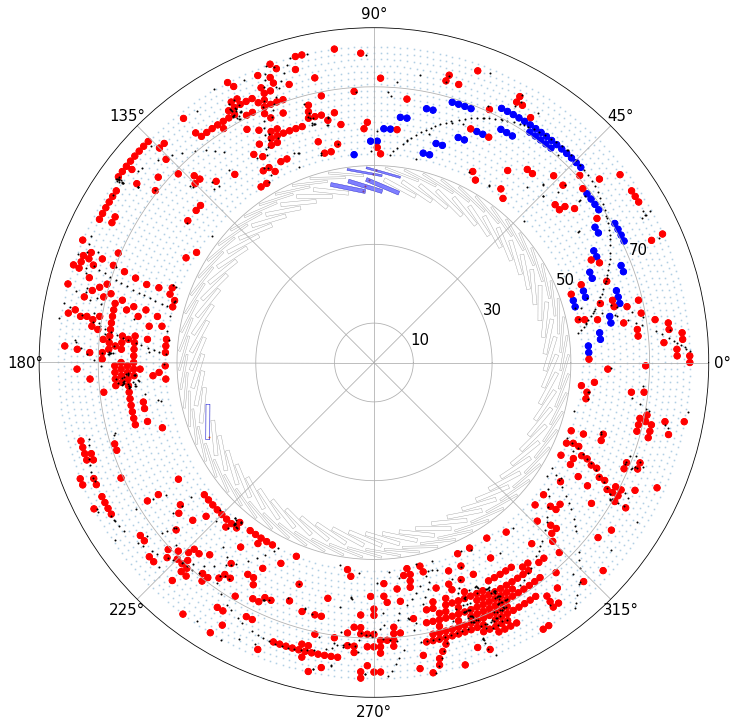

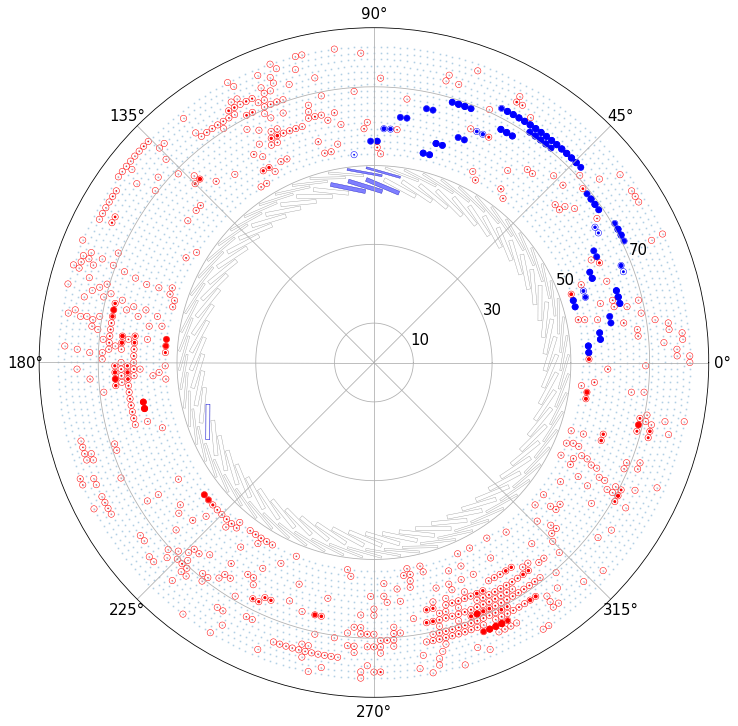

/home/five4three2/development/miniconda3/envs/tfy2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  
/home/five4three2/development/miniconda3/envs/tfy2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Length of draw tracks are 0


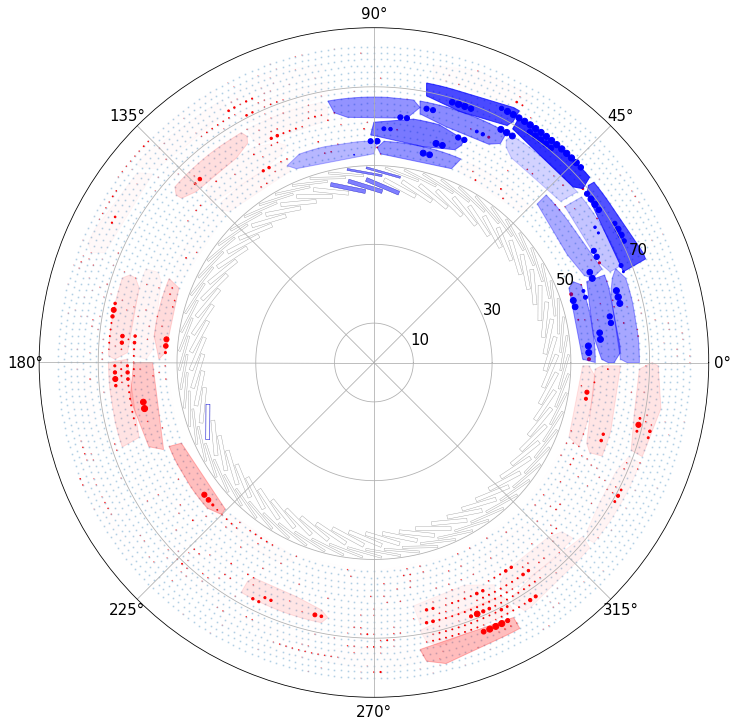

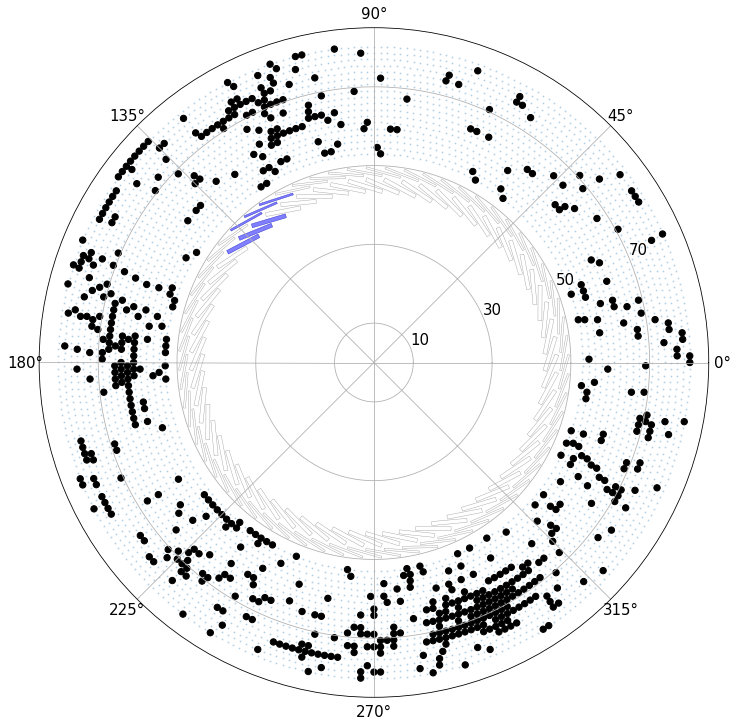

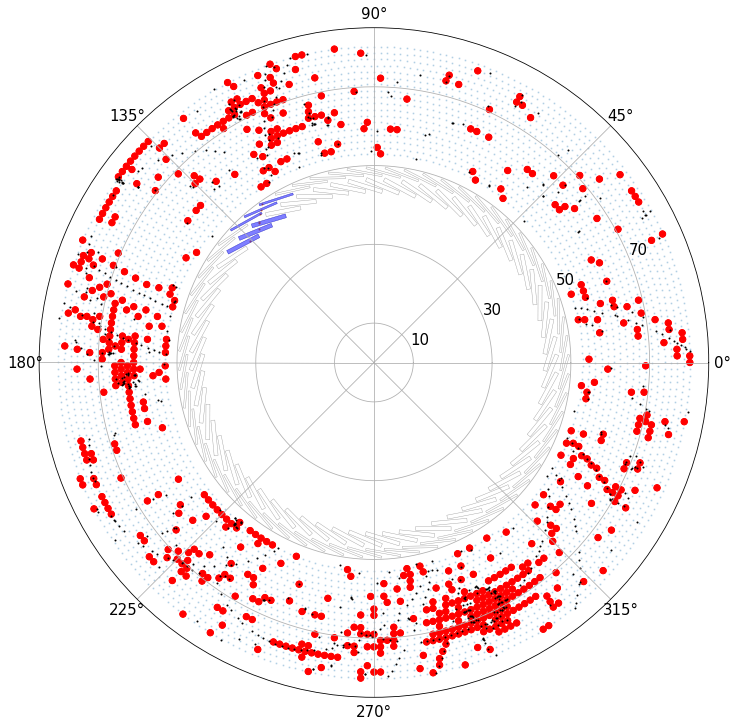

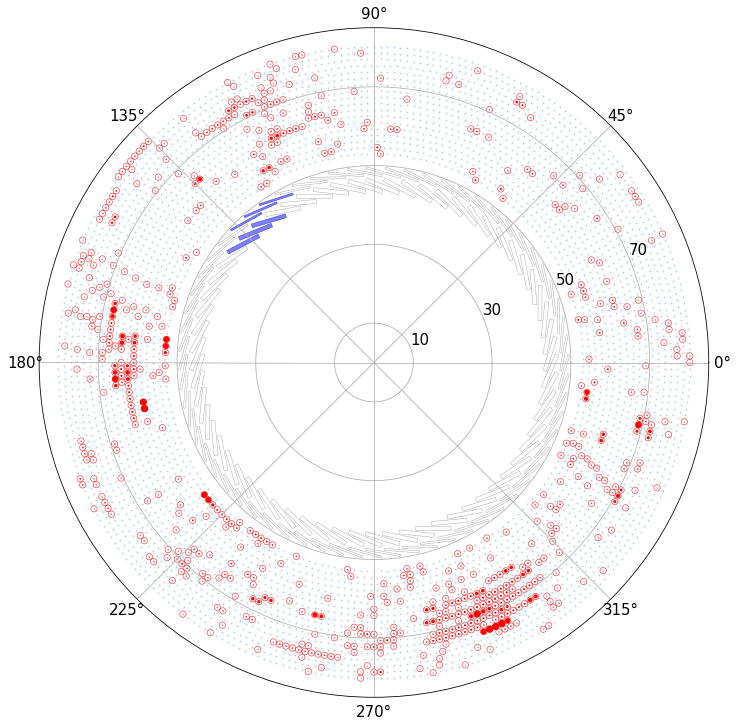

Length of draw tracks are 0


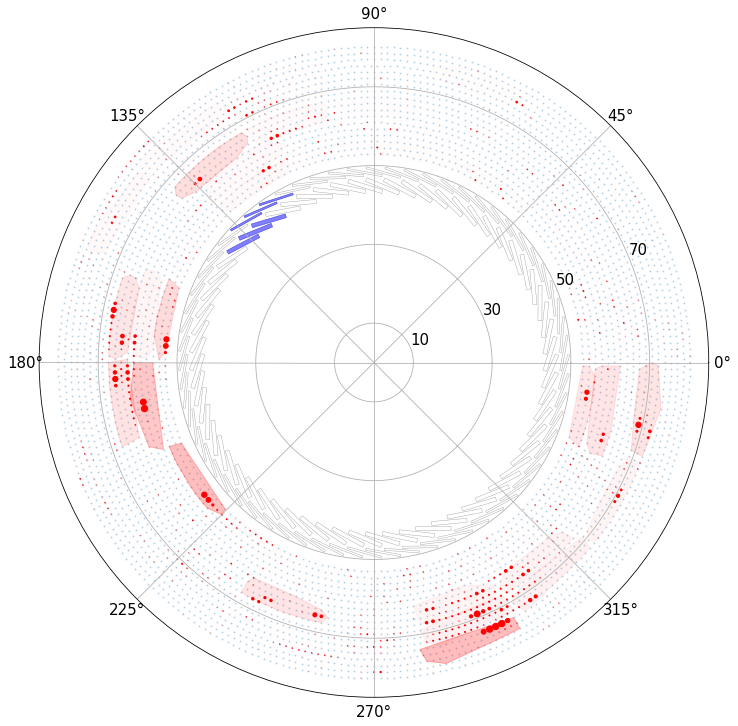

In [237]:
classifier = "High_Binned"
plot_recbes = True
geom = CDC(projection=0.0)

for a_evt in [4]:
    evt = good_event[a_evt]
    for samp, title in zip([sig_evts, bck_evts],
                           ["Signal", "Background"]):
        board_info = evt_scores[title]["boards"][classifier][evt]
        recbe_alpha = board_info[:,0] / board_info[:,1]
        # Plot the output
        output = np.zeros(4482)
        geom_ids = samp.cdc.get_measurement(samp.cdc.flat_name, evt).astype(int)
        a_cls, a_feat = factory[classifier]
        a_data = get_data_frame(samp, evt)[a_feat]
        output[geom_ids] = a_cls.predict_proba(a_data)[:,1]
        # Get the CTH volumes with hits
        cth_vol_types = samp.cth.get_vol_types(evt)
        # BW event
        plot_output(samp.cdc.get_hit_types(evt), geom, size=plot_norm_size(np.ones_like(output)), 
                    sig_color="black", bkg_color="black")
        plot_add_cth_outlines(samp.cth.geom)
        plot_add_cth(cth_vol_types, samp.cth.get_trig_vector(evt)[0], samp.cth.geom)
        if save_plots:
            plt.savefig(savedir+title+"_bbdt_bw_event.png", bbox_inches='tight', dpi=dpi_plots)
        plt.show()
        # Labelled event
        plot_output(samp.cdc.get_hit_types(evt), geom)
        plot_add_cth_outlines(samp.cth.geom)
        plot_add_cth(cth_vol_types, samp.cth.get_trig_vector(evt)[0], samp.cth.geom)
        plot_add_outlines(samp.cdc.get_hit_types(evt), geom)
        # Add truth tracks
        cth_hits = samp.cth.get_events(evt)
        cdc_hits = samp.cdc.get_events(evt)
        plt.scatter(-cth_hits[p["cth"]["x"]], 
                    -cth_hits[p["cth"]["y"]], 
                    s=1, transform=gca().transData._b)
        plt.scatter(-cdc_hits[p["cdc"]["x"]], 
                    -cdc_hits[p["cdc"]["y"]], 
                    s=1, color="black",
                    transform=gca().transData._b)
        if save_plots:
            plt.savefig(savedir+title+"_bbdt_plot_event.png", bbox_inches='tight', dpi=dpi_plots)
        plt.show()
        # Wire scaled eent event
        plot_output(samp.cdc.get_hit_types(evt), geom, size=plot_norm_size(output))
        plot_add_cth_outlines(samp.cth.geom)
        plot_add_cth(cth_vol_types, samp.cth.get_trig_vector(evt)[0], samp.cth.geom)
        plot_add_outlines(samp.cdc.get_hit_types(evt), geom)
        if save_plots:
            plt.savefig(savedir+title+"_bbdt_plot_event_wires.png", bbox_inches='tight', dpi=dpi_plots)
        plt.show()
        # Add hit outlines
        plot_output(samp.cdc.get_hit_types(evt), geom, size=plot_norm_size(output))
        plot_add_recbe(samp.cdc.get_hit_types(evt),geom, recbe_labels=board_info[:,2], 
                                                         recbe_alpha=recbe_alpha)
        plot_add_tracks(geom, hough, tolerance=0.0, 
                        size=plot_norm_size(hough_images[evt] - np.amin(hough_images[evt]),40))
        # Add volume outlines
        plot_add_cth_outlines(samp.cth.geom)
        # Add the CTH vols with hits
        cth_vol_types = samp.cth.get_vol_types(evt)
        plot_add_cth(cth_vol_types, samp.cth.get_trig_vector(evt)[0], samp.cth.geom)
        if save_plots:
            plt.savefig(savedir+title+"_bbdt_plot_event_boards.png", bbox_inches='tight', dpi=dpi_plots)        
        plt.show()
        print("=====================================================================")

# Scrap

In [70]:
for cla, ls in zip(['ADC','Binary','Binned','Unbinned'],
                   #['-', ':', '--', '-.']):
                   [':', '-.', '--', '-']):
    tpr = np.array(evt_curve_dict[cla][1])
    fpr = np.array(evt_curve_dict[cla][0])
    datum_label = "Event"
    label = cla_dict[cla]
    zoom=True
    zoom_x_lims=[80,100]
    zoom_y_lims=[50,100]
    fig = plt.figure(1)
    
    fpr *= 100.
    tpr *= 100.
    
    array_vals = np.rec.fromarrays((tpr, 100-fpr),  dtype=[('SigHitKeep', float), ('BackHitKeep', float)])
#    plt.plot(array_vals["SigHitKeep"], array_vals["BackHitKeep"])
    filename = cla_dict[cla].replace(" ", "_").replace("(", "").replace(")","") + "_event.root"
    print filename
    root_numpy.array2root(array_vals, filename)
    
    ax = fig.add_subplot(111)
    ax.plot(tpr, 100-fpr, label=label, c="black", linestyle=ls)
    ax.xaxis.tick_top()
    ax.set_xlabel('Signal '+datum_label+' Retention Efficiency')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Background '+datum_label+' Rejection Efficiency')    
    ax.grid(b=True, which='minor', color='grey', linestyle=':')
    ax.grid(b=True, which='major', color='grey', linestyle='--')

    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)
    ax.yaxis.set_major_formatter(xticks)

    ax.set_axisbelow(True)
    if zoom:
        ax.set_xlim(zoom_x_lims)
        ax.set_ylim(zoom_y_lims)
    ax.minorticks_on()
    # Deal with the legend
    ax.legend(loc=3, frameon=1)
    leg = ax.get_legend()
    frame = leg.get_frame()
    frame.set_facecolor('white')

KeyError: 'ADC'

In [ ]:
for cla, ls in zip(['ADC','Binary','Binned','Unbinned'],
                   ['-', ':', '--', '-.']):
                   #[':', '-.', '--', '-']):
    tpr = np.array(curve_dict[cla][1])
    fpr = np.array(curve_dict[cla][0])
    datum_label = "Hit"
    label = cla_dict[cla]
    zoom=True
    zoom_x_lims=[80,100]
    zoom_y_lims=[50,100]
    fig = plt.figure(1)
    
    fpr *= 100.
    tpr *= 100.
    
    array_vals = np.rec.fromarrays((tpr, 100-fpr),  dtype=[('SigHitKeep', float), ('BackHitKeep', float)])
#    plt.plot(array_vals["SigHitKeep"], array_vals["BackHitKeep"])
    filename = cla_dict[cla].replace(" ", "_").replace("(", "").replace(")","") + ".root"
    print filename
    root_numpy.array2root(array_vals, filename)
    
    ax = fig.add_subplot(111)
    ax.plot(tpr, 100-fpr, label=label, c="black", linestyle=ls)
    ax.xaxis.tick_top()
    ax.set_xlabel('Signal '+datum_label+' Retention Efficiency')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Background '+datum_label+' Rejection Efficiency')    
    ax.grid(b=True, which='minor', color='grey', linestyle=':')
    ax.grid(b=True, which='major', color='grey', linestyle='--')

    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)
    ax.yaxis.set_major_formatter(xticks)

    ax.set_axisbelow(True)
    if zoom:
        ax.set_xlim(zoom_x_lims)
        ax.set_ylim(zoom_y_lims)
    ax.minorticks_on()
    # Deal with the legend
    ax.legend(loc=3, frameon=1)
    leg = ax.get_legend()
    frame = leg.get_frame()
    frame.set_facecolor('white')